In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## MERRA2 T2M field vs. SAM, PSA1, PSA2, ASL CP Long. Position, SOI, Nino34, ASL CP Long. Position, and ASL CP Value
## Now includes vs. PDO (26Feb2019)

### Plot 5x1 (DJF, MAM, JJA, SON, ANN)
### no rolls (for some reason some are blank due to a unknown mask error)

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as pylab
import matplotlib.path as mpath
import datetime
import pandas as pd
from scipy.stats.stats import pearsonr
from scipy.stats import ttest_ind
from scipy import signal
from IPython.display import display
import xarray as xr
import dask as da
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
from dask.array.rechunk import rechunk
from mpl_toolkits.basemap import Basemap, addcyclic
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
import statsmodels.api as sm
from cartopy.util import add_cyclic_point
import netCDF4
from scipy import stats
import matplotlib.pyplot as plt

#for era
# from eofs.xarray import Eof
# from eofs.examples import example_data_path
# np.seterr(divide='ignore', invalid='ignore')

%matplotlib inline

In [3]:
############# to be set #############

                         
##Load ERA indice .pkl's
PICKLE_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_Indices_as_CSV_19Nov2018'

##Save figure file path
FIG_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Figures_For_REVIEW_Submission_24March2021'



In [4]:

##Specific to MERRA2, ie, not the same chunk and slices as iCESM
XCHUNK = 240 #Full size chunk seems to make things run quickest
YCHUNK = 121 #Full Y size chunk makes things run quickest
#ZCHUNK = 30 #Full Z size chunk 
TCHUNK = 456  #Full T size

##Find .nc file path
NETCDF_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_CTRL_LGM_ERA_Xarrays_as_netcdf_31Oct2018'



In [5]:
#For MERRA, decode_cf needs to be set to True for proper concatenation on T axis
MERRA_DATA = xr.open_dataset(NETCDF_PATH+'/MERRA_DATA.nc')
print(MERRA_DATA)

<xarray.Dataset>
Dimensions:  (lat: 121, lon: 240, time: 456)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2017-12-01
  * lat      (lat) float64 90.0 88.5 87.0 85.5 84.0 ... -85.5 -87.0 -88.5 -90.0
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
Data variables:
    skint    (time, lat, lon) float32 ...
    sst      (time, lat, lon) float32 ...
    msl      (time, lat, lon) float32 ...
    u10      (time, lat, lon) float32 ...
    v10      (time, lat, lon) float32 ...
    t2m      (time, lat, lon) float32 ...
    tp       (time, lat, lon) float32 ...
    ci       (time, lat, lon) float32 ...


In [6]:
#getting variables in right units 
slp_tmon_merra = MERRA_DATA.msl/100 #hPa
v10_tmon_merra = MERRA_DATA.v10 #in m/s at 10m
u10_tmon_merra = MERRA_DATA.u10 #in m/s at 10m
t2m_tmon_merra = MERRA_DATA.t2m-273.15 #in C
tp_tmon_merra  = MERRA_DATA.tp*60*60*24*1000/1000  #in mm/day
ci_tmon_merra  = MERRA_DATA.ci #in [0-1] fraction of sea ice
sst_tmon_merra = MERRA_DATA.sst #SST in C -- taken care of when making the xarray/.nc file


In [7]:
sst_tmon_merra

<xarray.DataArray 'sst' (time: 456, lat: 121, lon: 240)>
[13242240 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2017-12-01
  * lat      (lat) float64 90.0 88.5 87.0 85.5 84.0 ... -85.5 -87.0 -88.5 -90.0
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5

In [8]:
#Open pandas dfs of all indices and ASL information
# pdo_index_merra = pd.read_pickle(PICKLE_PATH+'/merra_pdo_tmon.pkl')
# # pdo_index_merra.head(n=5)
# pdo_seas_mean_index_merra = pd.read_pickle(PICKLE_PATH+'/merra_pdo_seas.pkl')
# # pdo_seas_mean_index_merra.head(n=5)
# pdo_ann_mean_index_merra = pd.read_pickle(PICKLE_PATH+'/merra_pdo_ann_mean.pkl')
# # pdo_ann_mean_index_merra.head(n=5)

# enso_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_epcs_tmon.pkl')
# # enso_indices_merra.head(n=5)
# enso_seas_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_epcs_seas.pkl')
# # enso_seas_mean_indices_merra.head(n=5)
# enso_ann_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_epcs_ann_mean.pkl')
# # enso_ann_mean_indices_merra.head(n=5)
# enso_12roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_epcs_12roll_mean.pkl')
# # enso_12roll_mean_indices_merra.head(n=10)
# enso_6roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_epcs_6roll_mean.pkl')
# # enso_6roll_mean_indices_merra.head(n=5)
# enso_3roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_epcs_3roll_mean.pkl')
# # enso_3roll_mean_indices_merra.head(n=5)
# enso_band_filt_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_epcs_band_filt.pkl')
# # enso_band_filt_indices_merra.head(n=5)

SAM_PSAs_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_sam_psas_tmon.pkl')
# SAM_PSAs_indices_merra.head(n=5)
SAM_PSAs_seas_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_sam_psas_seas.pkl')
# SAM_PSAs_seas_mean_indices_merra.head(n=5)
SAM_PSAs_ann_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_sam_psas_ann_mean.pkl')
# SAM_PSAs_ann_mean_indices_merra.head(n=5)
SAM_PSAs_12roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_sam_psas_12roll_mean.pkl')
# SAM_PSAs_12roll_mean_indices_merra.head(n=10)
SAM_PSAs_6roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_sam_psas_6roll_mean.pkl')
# SAM_PSAs_6roll_mean_indices_merra.head(n=5)
SAM_PSAs_3roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_sam_psas_3roll_mean.pkl')
# SAM_PSAs_3roll_mean_indices_merra.head(n=5)
SAM_PSAs_band_filt_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_sam_psas_band_filt.pkl')
# SAM_PSAs_band_filt_indices_merra.head(n=5)

# df_d18O_psuedoWDC_tmon_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoWDC_tmon.pkl')
# # df_d18O_psuedoWDC_tmon_merra.head(n=5)
# d18O_psuedoWDC_seas_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoWDC_seas.pkl')
# # d18O_psuedoWDC_seas_mean_merra.head(n=5)
# d18O_psuedoWDC_ann_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoWDC_ann_mean.pkl')
# # d18O_psuedoWDC_ann_mean_merra.head(n=5)
# d18O_psuedoWDC_12roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoWDC_12roll_mean.pkl')
# # d18O_psuedoWDC_12roll_mean_merra.head(n=10)
# d18O_psuedoWDC_6roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoWDC_6roll_mean.pkl')
# # d18O_psuedoWDC_6roll_mean_merra.head(n=5)
# d18O_psuedoWDC_3roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoWDC_3roll_mean.pkl')
# # d18O_psuedoWDC_3roll_mean_merra.head(n=5)
# d18O_psuedoWDC_band_filt_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoWDC_band_filt.pkl')
# # d18O_psuedoWDC_band_filt_merra.head(n=5)

# df_d18O_psuedowestcore_tmon_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedowestcore_tmon.pkl')
# # df_d18O_psuedowestcore_tmon_merra.head(n=5)
# d18O_psuedowestcore_seas_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedowestcore_seas.pkl')
# # d18O_psuedowestcore_seas_mean_merra.head(n=5)
# d18O_psuedowestcore_ann_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedowestcore_ann_mean.pkl')
# # d18O_psuedowestcore_ann_mean_merra.head(n=5)
# d18O_psuedowestcore_12roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedowestcore_12roll_mean.pkl')
# # d18O_psuedowestcore_12roll_mean_merra.head(n=10)
# d18O_psuedowestcore_6roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedowestcore_6roll_mean.pkl')
# # d18O_psuedowestcore_6roll_mean_merra.head(n=5)
# d18O_psuedowestcore_3roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedowestcore_3roll_mean.pkl')
# # d18O_psuedowestcore_3roll_mean_merra.head(n=5)
# d18O_psuedowestcore_band_filt_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedowestcore_band_filt.pkl')
# # d18O_psuedowestcore_band_filt_merra.head(n=5)

# df_d18O_psuedoeastcore_tmon_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoeastcore_tmon.pkl')
# # df_d18O_psuedoeastcore_tmon_merra.head(n=5)
# d18O_psuedoeastcore_seas_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoeastcore_seas.pkl')
# # d18O_psuedoeastcore_seas_mean_merra.head(n=5)
# d18O_psuedoeastcore_ann_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoeastcore_ann_mean.pkl')
# # d18O_psuedoeastcore_ann_mean_merra.head(n=5)
# d18O_psuedoeastcore_12roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoeastcore_12roll_mean.pkl')
# # d18O_psuedoeastcore_12roll_mean_merra.head(n=10)
# d18O_psuedoeastcore_6roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoeastcore_6roll_mean.pkl')
# # d18O_psuedoeastcore_6roll_mean_merra.head(n=5)
# d18O_psuedoeastcore_3roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoeastcore_3roll_mean.pkl')
# # d18O_psuedoeastcore_3roll_mean_merra.head(n=5)
# d18O_psuedoeastcore_band_filt_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoeastcore_band_filt.pkl')
# # d18O_psuedoeastcore_band_filt_merra.head(n=5)

# d18O_wais_pcs_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_wais_pcs_tmon.pkl')
# # d18O_wais_pcs_merra.head(n=5)
# d18O_wais_pcs_seas_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_wais_pcs_seas.pkl')
# # d18O_wais_pcs_seas_mean_merra.head(n=5)
# d18O_wais_pcs_ann_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_wais_pcs_ann_mean.pkl')
# # d18O_wais_pcs_ann_mean_merra.head(n=5)
# d18O_wais_pcs_12roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_wais_pcs_12roll_mean.pkl')
# # d18O_wais_pcs_12roll_mean_merra.head(n=12)
# d18O_wais_pcs_6roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_wais_pcs_6roll_mean.pkl')
# # d18O_wais_pcs_6roll_mean_merra.head(n=5)
# d18O_wais_pcs_3roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_wais_pcs_3roll_mean.pkl')
# # d18O_wais_pcs_3roll_mean_merra.head(n=5)
# d18O_wais_pcs_band_filt_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_wais_pcs_band_filt.pkl')
# # d18O_wais_pcs_band_filt_merra.head(n=5)

# monthly_Rel_CP_Anoms_Detrend_Norm_loc_info_merra_df = pd.read_pickle(PICKLE_PATH+'/merra_Rel_CP_tmon.pkl')
# # monthly_Rel_CP_Anoms_Detrend_Norm_loc_info_merra_df.head(n=5)
# Rel_CP_seas_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Rel_CP_seas_mean.pkl')
# # Rel_CP_seas_mean_indices_merra.head(n=5)
# Rel_CP_ann_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Rel_CP_ann_mean.pkl')
# # Rel_CP_ann_mean_indices_merra.head(n=5)
# Rel_CP_12roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Rel_CP_12roll_mean.pkl')
# # Rel_CP_12roll_mean_indices_merra.head(n=10)
# Rel_CP_6roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Rel_CP_6roll_mean.pkl')
# # Rel_CP_6roll_mean_indices_merra.head(n=5)
# Rel_CP_3roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Rel_CP_3roll_mean.pkl')
# # Rel_CP_3roll_mean_indices_merra.head(n=5)
# Rel_CP_band_filt_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Rel_CP_band_filt.pkl')
# # Rel_CP_band_filt_indices_merra.head(n=5)

# monthly_Abs_CP_Anoms_Detrend_Norm_loc_info_merra_df = pd.read_pickle(PICKLE_PATH+'/merra_Abs_CP_tmon.pkl')
# # monthly_Abs_CP_Anoms_Detrend_Norm_loc_info_merra_df.head(n=5)
# Abs_CP_seas_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Abs_CP_seas_mean.pkl')
# # Abs_CP_seas_mean_indices_merra.head(n=5)
# Abs_CP_ann_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Abs_CP_ann_mean.pkl')
# # Abs_CP_ann_mean_indices_merra.head(n=5)
# Abs_CP_12roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Abs_CP_12roll_mean.pkl')
# # Abs_CP_12roll_mean_indices_merra.head(n=10)
# Abs_CP_6roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Abs_CP_6roll_mean.pkl')
# # Abs_CP_6roll_mean_indices_merra.head(n=5)
# Abs_CP_3roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Abs_CP_3roll_mean.pkl')
# # Abs_CP_3roll_mean_indices_merra.head(n=5)
# Abs_CP_band_filt_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Abs_CP_band_filt.pkl')
# # Abs_CP_band_filt_indices_merra.head(n=5)



#Raw Rel and Abs CP Info .... needed for actual lon lat position and values
# monthly_Rel_CP_raw_merra_df = pd.read_pickle(PICKLE_PATH+'/merra_Rel_CP_Raw_Info_tmon.pkl')
# monthly_Rel_CP_raw_merra_df.head(n=5)
Rel_CP_djf_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_djf_mean.pkl')
# Rel_CP_djf_mean_indices_raw_merra.head(n=5)
Rel_CP_mam_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_mam_mean.pkl')
# Rel_CP_mam_mean_indices_raw_merra.head(n=5)
Rel_CP_jja_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_jja_mean.pkl')
# Rel_CP_jja_mean_indices_raw_merra.head(n=5)
Rel_CP_son_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_son_mean.pkl')
# Rel_CP_son_mean_indices_raw_merra.head(n=5)
Rel_CP_ann_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_ann_mean.pkl')
# Rel_CP_ann_mean_indices_raw_merra.head(n=5)
# Rel_CP_12roll_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_12roll_mean.pkl')
# # Rel_CP_12roll_mean_indices_raw_merra.head(n=10)
# Rel_CP_6roll_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_6roll_mean.pkl')
# # Rel_CP_6roll_mean_indices_raw_merra.head(n=5)
# Rel_CP_3roll_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_3roll_mean.pkl')
# Rel_CP_3roll_mean_indices_raw_merra.head(n=5)
# Rel_CP_band_filt_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_Rel_CP_Raw_Info_band_filt.pkl')
# # Rel_CP_band_filt_indices_raw_merra.head(n=5)




In [9]:
# enso_seas_mean_indices_merra.head(n=5)

In [10]:
Rel_CP_djf_mean_indices_raw_merra.head(n=5)

,vals,lats,lons,sectormean,indice
time,,,,,
1980-12-01,-5.507777,-70.5,276.0,988.218715,0
1981-12-01,-5.032051,-69.0,265.5,986.659493,1
1982-12-01,-8.317850,-64.5,279.0,994.900186,2
1983-12-01,-6.575958,-67.5,253.5,989.702972,3
1984-12-01,-4.701659,-66.0,264.0,990.748289,4


In [11]:
Rel_CP_ann_mean_indices_raw_merra.head(n=5)

,vals,lats,lons,sectormean,indice
time,,,,,
1980-01-01,-4.454987,-73.5,207.0,990.259126,0
1981-01-01,-4.978481,-72.0,214.5,987.240688,1
1982-01-01,-5.265890,-73.5,205.5,986.160849,2
1983-01-01,-5.715246,-70.5,253.5,985.146704,3
1984-01-01,-5.524716,-75.0,207.0,986.935604,4


## Detrending the T2M variable. Will calculate the change in this variable dependent on the sign of the various indices (starting with SAM, PSA1, PSA2)

In [12]:
#params to be set
time_lo     = '1980-01-01'
time_hi    = '2017-12-31'  

# trop_pac_xhi = 290
# trop_pac_xlo = 110
# trop_pac_yhi = 20 
# trop_pac_ylo = -20  

# asl_xhi_slice = 298
# asl_xlo_slice = 170
# asl_yhi_slice = -59.6 #need to go a bit passed 60S to get a full grid point
# asl_ylo_slice = -80

# shem_xhi_slice = 362.5 #trying this, doesnt change ... still missing data from 357.5 to 360 
# shem_xlo_slice = 0
# shem_yhi_slice = -45
# shem_ylo_slice = -90

shem_yhi = -90 #reversed hi and lo lat values for ERA
shem_ylo = -20  #reversed hi and lo lat values for ERA

In [13]:
t2m_shem_tmon_merra = t2m_tmon_merra.sel(time=slice(time_lo, time_hi), lat=slice(shem_ylo, shem_yhi))

#Detrend Southern Hem t2m; use of scipy
#has some missing values, need to fill those with zeros 
#requires remapping back to xr dataArray 
#Returns the detrended t2m data 
#the print lines help determine the shape and number of nans

aa1 = signal.detrend(t2m_shem_tmon_merra.fillna(0.), axis=0, type='linear', bp=0)
# print(4, aa1[0,25,11])
# print(5, aa1[0,25,33])
# print(6, np.count_nonzero(aa1[0,:,:]))


aa2 = xr.DataArray(aa1, coords={'time': t2m_shem_tmon_merra.coords['time'], 'lat': t2m_shem_tmon_merra.coords['lat'],'lon': t2m_shem_tmon_merra.coords['lon']}, dims=('time','lat','lon'))
# print(7, aa2[0,25,11].values)
# print(8, aa2[0,25,33].values)
# print(9, np.count_nonzero(aa2[0,:,:]))

t2m_shem_tmon_detrend_merra = aa2.where(aa2 != 0.00000, np.nan)
# t2m_shem_tmon_detrend_merra


#In case I eventually want the t2m to have climatology removed and normalized, that is done below
#Create t2m Monthly Climatology from detrended data using data from time_lo to time_hi
t2m_detrend_shem_climatology_merra = t2m_shem_tmon_detrend_merra.sel(time=slice(time_lo, time_hi)).groupby('time.month').mean('time')
# t2m_detrend_shem_climatology_merra

#Find Southern Hemisphere t2m Anoms using the climatology from time_lo to time_hi
t2m_anoms_shem_tmon_detrend_merra = t2m_shem_tmon_detrend_merra.groupby('time.month') - t2m_detrend_shem_climatology_merra

#Normalize Southern Hemisphere t2m Anoms (from detrended data)
t2m_anoms_shem_tmon_detrend_norm_merra = (t2m_anoms_shem_tmon_detrend_merra - t2m_anoms_shem_tmon_detrend_merra.mean(dim='time'))/t2m_anoms_shem_tmon_detrend_merra.std(dim='time')
# t2m_anoms_shem_tmon_detrend_norm_merra


### Find the Difference in T2M values due to Upper Quartile vs. Lower Quartile SAM across the 8 time periods

### Calculate the significance of the difference and mark with contours 

In [14]:
SAM_PSAs_seas_mean_indices_merra.head(n=5)

,SAM,PSA1,PSA2,Seas_Index
time,,,,
1980-03-01,-1.069458,0.236233,-0.549796,03
1980-06-01,-0.394065,-0.462641,-0.779531,06
1980-09-01,-0.591505,0.042762,0.298846,09
1980-12-01,0.036406,0.092091,-0.021163,12
1981-03-01,-0.690965,-0.213709,0.451755,03


#### Change Field variable into seasonal means and rolls and annual mean

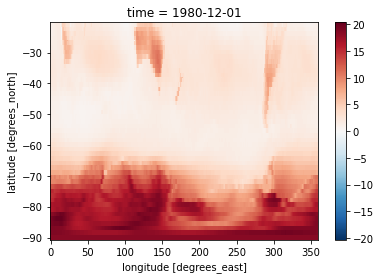

In [15]:
#Seasonal Mean of Field Variable, just an example here to make sure my method below is correct
t2m_shem_seas_mean_detrend_merra = t2m_shem_tmon_detrend_merra[2:(len(t2m_shem_tmon_detrend_merra['time'])-1)].resample(time='QS-MAR', closed='left'  ).mean(dim='time')
t2m_shem_seas_mean_detrend_merra[3].plot()

<xarray.DataArray (time: 37, lat: 47, lon: 240)>
array([[[ 1.0701542,  1.1168867,  1.1659628, ...,  0.8857905,
          0.9300232,  1.0033016],
        [ 1.1476326,  1.1708788,  1.217907 , ...,  1.0001634,
          1.0310339,  1.1010355],
        [ 1.2609692,  1.2376512,  1.2652378, ...,  1.2133375,
          1.1862112,  1.2434254],
        ...,
        [18.91467  , 18.935478 , 18.951193 , ..., 18.830976 ,
         18.860987 , 18.889484 ],
        [19.076078 , 19.053686 , 19.032604 , ..., 19.147303 ,
         19.123957 , 19.100206 ],
        [18.518518 , 18.518518 , 18.518518 , ..., 18.518518 ,
         18.518518 , 18.518518 ]],

       [[ 1.1691824,  1.2271284,  1.3213915, ...,  0.9814027,
          1.0312678,  1.0674692],
        [ 1.2145195,  1.2749811,  1.3280869, ...,  1.0631632,
          1.0827707,  1.1461912],
        [ 1.2309875,  1.3070431,  1.310957 , ...,  1.1711578,
          1.1364359,  1.1676172],
...
        [16.010622 , 16.017065 , 16.019354 , ..., 15.970776 ,
      

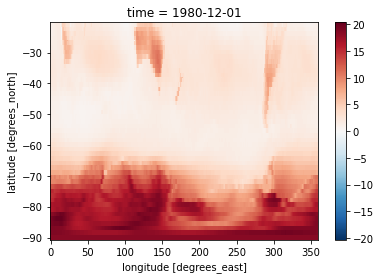

In [16]:
#Seperating out those seasonal means of the field variable
def is_djf(month):
    return (month == 12)

def is_mam(month):
    return (month == 3)

def is_jja(month):
    return (month == 6)

def is_son(month):
    return (month == 9)

djf_t2m_shem_seas_mean_detrend_merra = t2m_shem_seas_mean_detrend_merra.sel(time=is_djf(t2m_shem_seas_mean_detrend_merra['time.month']))
mam_t2m_shem_seas_mean_detrend_merra = t2m_shem_seas_mean_detrend_merra.sel(time=is_mam(t2m_shem_seas_mean_detrend_merra['time.month']))
jja_t2m_shem_seas_mean_detrend_merra = t2m_shem_seas_mean_detrend_merra.sel(time=is_jja(t2m_shem_seas_mean_detrend_merra['time.month']))
son_t2m_shem_seas_mean_detrend_merra = t2m_shem_seas_mean_detrend_merra.sel(time=is_son(t2m_shem_seas_mean_detrend_merra['time.month']))

#note, the first djf is dated for the first year because the 3-month mean is labeled by the first month
djf_t2m_shem_seas_mean_detrend_merra[0].plot()
print(djf_t2m_shem_seas_mean_detrend_merra)

#In case I need to add NaNs in djf, something like this may work:
# #need to add back in at time=0 a row of nans for djf, else it has 47 instead of 48 points
# nan_slice_for_djf = djfmean_T2M_tmon_merra_data[0:1,:,:]
# nan_slice_for_djf = nan_slice_for_djf.where(nan_slice_for_djf == 99999.)
# djfmean_T2M_tmon_merra_data = xr.concat([nan_slice_for_djf, djfmean_T2M_tmon_merra_data], dim='time')
# #djfmean_T2M_tmon_merra_data

In [17]:
#Field variable with 3,6,12 roll and annual mean

t2m_shem_ann_mean_detrend_merra = t2m_shem_tmon_detrend_merra.resample(time='AS').mean(dim='time')
#t2m_shem_ann_mean_detrend_merra

In [18]:
#Find SAM values for each of the 8 time periods and put in pd.DataFrame
#Then, select the upper and lower quartile values

d = {'SAM': SAM_PSAs_seas_mean_indices_merra.SAM.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '12').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.SAM.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '12').dropna()),1)}
SAM_djf_mean_merra = pd.DataFrame(data=d)
# SAM_djf_mean_merra

d = {'SAM': SAM_PSAs_seas_mean_indices_merra.SAM.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '03').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.SAM.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '03').dropna()),1)}
SAM_mam_mean_merra = pd.DataFrame(data=d)
# SAM_mam_mean_merra

d = {'SAM': SAM_PSAs_seas_mean_indices_merra.SAM.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '06').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.SAM.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '06').dropna()),1)}
SAM_jja_mean_merra = pd.DataFrame(data=d)
# SAM_jja_mean_merra

d = {'SAM': SAM_PSAs_seas_mean_indices_merra.SAM.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '09').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.SAM.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '09').dropna()),1)}
SAM_son_mean_merra = pd.DataFrame(data=d)
# SAM_son_mean_merra

d = {'SAM': SAM_PSAs_ann_mean_indices_merra.SAM.dropna(), 'indice': np.arange(0, len(SAM_PSAs_ann_mean_indices_merra.SAM.dropna()),1)}
SAM_ann_mean_merra = pd.DataFrame(data=d)
# SAM_ann_mean_merra


#create list of indices representing the upper/lower quartiles of 'SAM'
#Note, head is lower (sorted from low to high)
SAM_djf_mean_lower_merra = SAM_djf_mean_merra.sort_values(by=['SAM']).head(n=(round(SAM_djf_mean_merra.indice.size/4))).indice.tolist()
# SAM_djf_mean_lower_merra
SAM_djf_mean_upper_merra = SAM_djf_mean_merra.sort_values(by=['SAM']).tail(n=(round(SAM_djf_mean_merra.indice.size/4))).indice.tolist()
# SAM_djf_mean_upper_merra

SAM_mam_mean_lower_merra = SAM_mam_mean_merra.sort_values(by=['SAM']).head(n=(round(SAM_mam_mean_merra.indice.size/4))).indice.tolist()
# SAM_mam_mean_lower_merra
SAM_mam_mean_upper_merra = SAM_mam_mean_merra.sort_values(by=['SAM']).tail(n=(round(SAM_mam_mean_merra.indice.size/4))).indice.tolist()
# SAM_mam_mean_upper_merra

SAM_jja_mean_lower_merra = SAM_jja_mean_merra.sort_values(by=['SAM']).head(n=(round(SAM_jja_mean_merra.indice.size/4))).indice.tolist()
# SAM_jja_mean_lower_merra
SAM_jja_mean_upper_merra = SAM_jja_mean_merra.sort_values(by=['SAM']).tail(n=(round(SAM_jja_mean_merra.indice.size/4))).indice.tolist()
# SAM_jja_mean_upper_merra

SAM_son_mean_lower_merra = SAM_son_mean_merra.sort_values(by=['SAM']).head(n=(round(SAM_son_mean_merra.indice.size/4))).indice.tolist()
# SAM_son_mean_lower_merra
SAM_son_mean_upper_merra = SAM_son_mean_merra.sort_values(by=['SAM']).tail(n=(round(SAM_son_mean_merra.indice.size/4))).indice.tolist()
# SAM_son_mean_upper_merra

SAM_ann_mean_lower_merra = SAM_ann_mean_merra.sort_values(by=['SAM']).head(n=(round(SAM_ann_mean_merra.indice.size/4))).indice.tolist()
# SAM_ann_mean_lower_merra
SAM_ann_mean_upper_merra = SAM_ann_mean_merra.sort_values(by=['SAM']).tail(n=(round(SAM_ann_mean_merra.indice.size/4))).indice.tolist()
# SAM_ann_mean_upper_merra

In [19]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_t2m_w_upper_SAM_detrend_merra = djf_t2m_shem_seas_mean_detrend_merra.isel(time = SAM_djf_mean_upper_merra)
djf_t2m_w_lower_SAM_detrend_merra = djf_t2m_shem_seas_mean_detrend_merra.isel(time = SAM_djf_mean_lower_merra)
# djf_t2m_w_upper_SAM_detrend_merra
# djf_t2m_w_lower_SAM_detrend_merra

#mam
mam_t2m_w_upper_SAM_detrend_merra = mam_t2m_shem_seas_mean_detrend_merra.isel(time = SAM_mam_mean_upper_merra)
mam_t2m_w_lower_SAM_detrend_merra = mam_t2m_shem_seas_mean_detrend_merra.isel(time = SAM_mam_mean_lower_merra)
# mam_t2m_w_upper_SAM_detrend_merra
# mam_t2m_w_lower_SAM_detrend_merra

#jja
jja_t2m_w_upper_SAM_detrend_merra = jja_t2m_shem_seas_mean_detrend_merra.isel(time = SAM_jja_mean_upper_merra)
jja_t2m_w_lower_SAM_detrend_merra = jja_t2m_shem_seas_mean_detrend_merra.isel(time = SAM_jja_mean_lower_merra)
# jja_t2m_w_upper_SAM_detrend_merra
# jja_t2m_w_lower_SAM_detrend_merra

#son
son_t2m_w_upper_SAM_detrend_merra = son_t2m_shem_seas_mean_detrend_merra.isel(time = SAM_son_mean_upper_merra)
son_t2m_w_lower_SAM_detrend_merra = son_t2m_shem_seas_mean_detrend_merra.isel(time = SAM_son_mean_lower_merra)
son_t2m_w_upper_SAM_detrend_merra
# son_t2m_w_lower_SAM_detrend_merra

#ann mean
ann_mean_t2m_w_upper_SAM_detrend_merra = t2m_shem_ann_mean_detrend_merra.isel(time = SAM_ann_mean_upper_merra)
ann_mean_t2m_w_lower_SAM_detrend_merra = t2m_shem_ann_mean_detrend_merra.isel(time = SAM_ann_mean_lower_merra)
# ann_mean_t2m_w_upper_SAM_detrend_merra
# ann_mean_t2m_w_lower_SAM_detrend_merra


In [20]:
#Select ASL Rel CP value, long, and lat while index is in upper or lower quartile
#Using new ASL info from 19Nov2018
#djf
djf_Rel_CP_indices_w_upper_SAM_detrend_merra = Rel_CP_djf_mean_indices_raw_merra.iloc[SAM_djf_mean_upper_merra]
# djf_Rel_CP_indices_w_upper_SAM_detrend_merra
djf_Rel_CP_indices_w_lower_SAM_detrend_merra = Rel_CP_djf_mean_indices_raw_merra.iloc[SAM_djf_mean_lower_merra]
# djf_Rel_CP_indices_w_lower_SAM_detrend_merra

#mam
mam_Rel_CP_indices_w_upper_SAM_detrend_merra = Rel_CP_mam_mean_indices_raw_merra.iloc[SAM_mam_mean_upper_merra]
# mam_Rel_CP_indices_w_upper_SAM_detrend_merra
mam_Rel_CP_indices_w_lower_SAM_detrend_merra = Rel_CP_mam_mean_indices_raw_merra.iloc[SAM_mam_mean_lower_merra]
# mam_Rel_CP_indices_w_lower_SAM_detrend_merra

#jja
jja_Rel_CP_indices_w_upper_SAM_detrend_merra = Rel_CP_jja_mean_indices_raw_merra.iloc[SAM_jja_mean_upper_merra]
# jja_Rel_CP_indices_w_upper_SAM_detrend_merra
jja_Rel_CP_indices_w_lower_SAM_detrend_merra = Rel_CP_jja_mean_indices_raw_merra.iloc[SAM_jja_mean_lower_merra]
# jja_Rel_CP_indices_w_lower_SAM_detrend_merra

#son
son_Rel_CP_indices_w_upper_SAM_detrend_merra = Rel_CP_son_mean_indices_raw_merra.iloc[SAM_son_mean_upper_merra]
# son_Rel_CP_indices_w_upper_SAM_detrend_merra
son_Rel_CP_indices_w_lower_SAM_detrend_merra = Rel_CP_son_mean_indices_raw_merra.iloc[SAM_son_mean_lower_merra]
# son_Rel_CP_indices_w_lower_SAM_detrend_merra

#annual mean
ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra = Rel_CP_ann_mean_indices_raw_merra.iloc[SAM_ann_mean_upper_merra]
# ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra
ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra = Rel_CP_ann_mean_indices_raw_merra.iloc[SAM_ann_mean_lower_merra]
# ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra



In [21]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#Seasonal and ann mean, df=19+19-2 = 36 ; critical value = +- 2.028
#DJF, df =18+18-2 = 34 ; critical value = +- 2.032 (so close to df=36 that I am not going to change)

djf_t2m_change_due_to_SAM_ttest_stats_merra, djf_t2m_change_due_to_SAM_ttest_pvals_merra = ttest_ind(
    djf_t2m_w_upper_SAM_detrend_merra, djf_t2m_w_lower_SAM_detrend_merra, axis=0)

mam_t2m_change_due_to_SAM_ttest_stats_merra, mam_t2m_change_due_to_SAM_ttest_pvals_merra = ttest_ind(
    mam_t2m_w_upper_SAM_detrend_merra, mam_t2m_w_lower_SAM_detrend_merra, axis=0)

jja_t2m_change_due_to_SAM_ttest_stats_merra, jja_t2m_change_due_to_SAM_ttest_pvals_merra = ttest_ind(
    jja_t2m_w_upper_SAM_detrend_merra, jja_t2m_w_lower_SAM_detrend_merra, axis=0)

son_t2m_change_due_to_SAM_ttest_stats_merra, son_t2m_change_due_to_SAM_ttest_pvals_merra = ttest_ind(
    son_t2m_w_upper_SAM_detrend_merra, son_t2m_w_lower_SAM_detrend_merra, axis=0)

ann_mean_t2m_change_due_to_SAM_ttest_stats_merra, ann_mean_t2m_change_due_to_SAM_ttest_pvals_merra = ttest_ind(
    ann_mean_t2m_w_upper_SAM_detrend_merra, ann_mean_t2m_w_lower_SAM_detrend_merra, axis=0)

In [22]:
djf_Rel_CP_indices_w_upper_SAM_detrend_merra

,vals,lats,lons,sectormean,indice
time,,,,,
1994-12-01,-4.544594,-73.5,195.0,985.821449,14
1993-12-01,-5.380889,-69.0,252.0,985.286345,13
2014-12-01,-6.919812,-70.5,231.0,983.837781,34
1988-12-01,-5.985875,-66.0,265.5,983.095800,8
1998-12-01,-7.525349,-69.0,271.5,983.347797,18
2011-12-01,-5.374749,-69.0,277.5,984.563531,31
2007-12-01,-5.334884,-70.5,262.5,983.190841,27
2001-12-01,-8.972011,-69.0,267.0,982.985439,21
1999-12-01,-6.310391,-69.0,273.0,983.639004,19


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-6.260950395785244 -5.040241222356776


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-7.705617512215656 -6.652863124014277


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-8.581004670485925 -7.325814611210513


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-8.019623852207735 -6.604610531623814


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:351: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-6.069207265795103 -5.398468043874834


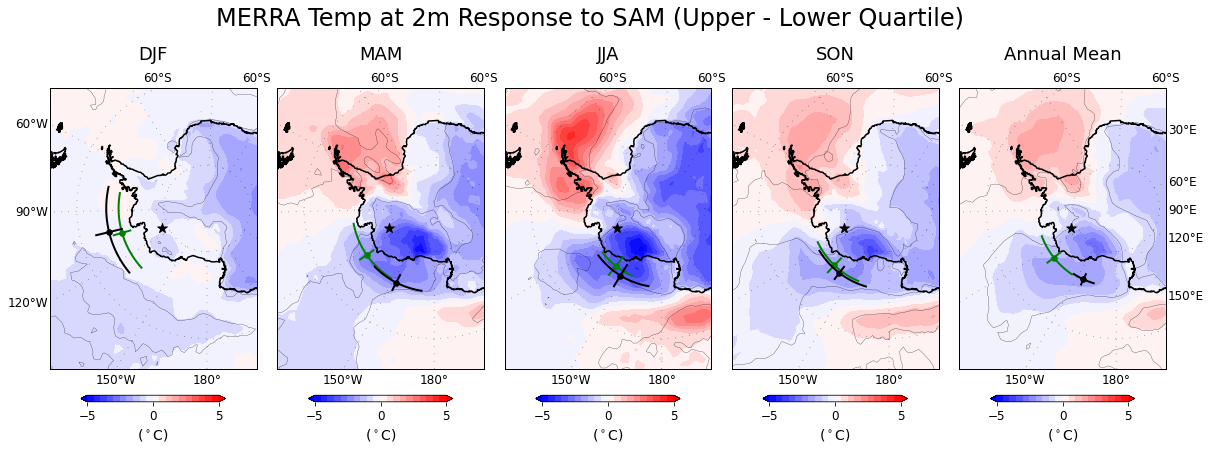

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('MERRA Temp at 2m Response to SAM (Upper - Lower Quartile)', fontsize=24, y=1.05)

# setup Lambert Conformal basemap.
diff_djf = djf_t2m_w_upper_SAM_detrend_merra.mean(axis=0)-djf_t2m_w_lower_SAM_detrend_merra.mean(axis=0)
diff_mam = mam_t2m_w_upper_SAM_detrend_merra.mean(axis=0)-mam_t2m_w_lower_SAM_detrend_merra.mean(axis=0)
diff_jja = jja_t2m_w_upper_SAM_detrend_merra.mean(axis=0)-jja_t2m_w_lower_SAM_detrend_merra.mean(axis=0)
diff_son = son_t2m_w_upper_SAM_detrend_merra.mean(axis=0)-son_t2m_w_lower_SAM_detrend_merra.mean(axis=0)
diff_ann = ann_mean_t2m_w_upper_SAM_detrend_merra.mean(axis=0)-ann_mean_t2m_w_lower_SAM_detrend_merra.mean(axis=0)
diff_djf_sh, lons = add_cyclic_point(diff_djf.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_mam_sh, lons = add_cyclic_point(diff_mam.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_jja_sh, lons = add_cyclic_point(diff_jja.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_son_sh, lons = add_cyclic_point(diff_son.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_ann_sh, lons = add_cyclic_point(diff_ann.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_djf_con, lons = add_cyclic_point(djf_t2m_change_due_to_SAM_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)
diff_mam_con, lons = add_cyclic_point(mam_t2m_change_due_to_SAM_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)
diff_jja_con, lons = add_cyclic_point(jja_t2m_change_due_to_SAM_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)
diff_son_con, lons = add_cyclic_point(son_t2m_change_due_to_SAM_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)
diff_ann_con, lons = add_cyclic_point(ann_mean_t2m_change_due_to_SAM_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)

lon, lat = np.meshgrid(lons,MERRA_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-5,5.5,.5)
levels_contour = [-2.101,2.101] #good for seasons and annual mean

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(djf_t2m_w_upper_SAM_detrend_merra.mean(axis=0)-djf_t2m_w_lower_SAM_detrend_merra.mean(axis=0)).where((djf_t2m_change_due_to_SAM_ttest_stats_merra >= levels_contour[1]) | (djf_t2m_change_due_to_SAM_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
# CS = m.contourf(x,y,(djf_t2m_w_upper_SAM_detrend_merra.mean(axis=0)-djf_t2m_w_lower_SAM_detrend_merra.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_djf_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_djf_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.vals.mean(),djf_Rel_CP_indices_w_lower_SAM_detrend_merra.vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(mam_t2m_w_upper_SAM_detrend_merra.mean(axis=0)-mam_t2m_w_lower_SAM_detrend_merra.mean(axis=0)).where((mam_t2m_change_due_to_SAM_ttest_stats_merra >= levels_contour[1]) | (mam_t2m_change_due_to_SAM_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_mam_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_mam_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean(),
            mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean(),
            mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()+mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()-mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()+mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()-mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()+mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()-mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()+mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()-mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Rel_CP_indices_w_upper_SAM_detrend_merra.vals.mean(),mam_Rel_CP_indices_w_lower_SAM_detrend_merra.vals.mean())


#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(jja_t2m_w_upper_SAM_detrend_merra.mean(axis=0)-jja_t2m_w_lower_SAM_detrend_merra.mean(axis=0)).where((jja_t2m_change_due_to_SAM_ttest_stats_merra >= levels_contour[1]) | (jja_t2m_change_due_to_SAM_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_jja_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_jja_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.vals.mean(),jja_Rel_CP_indices_w_lower_SAM_detrend_merra.vals.mean())


#SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(son_t2m_w_upper_SAM_detrend_merra.mean(axis=0)-son_t2m_w_lower_SAM_detrend_merra.mean(axis=0)).where((son_t2m_change_due_to_SAM_ttest_stats_merra >= levels_contour[1]) | (son_t2m_change_due_to_SAM_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_son_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_son_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(son_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean(),
            son_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(son_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean(),
            son_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(son_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,son_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()+son_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,son_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()-son_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()+son_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,son_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()-son_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,son_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(son_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,son_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()+son_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,son_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()-son_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()+son_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,son_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()-son_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,son_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Rel_CP_indices_w_upper_SAM_detrend_merra.vals.mean(),son_Rel_CP_indices_w_lower_SAM_detrend_merra.vals.mean())


#Annual Mean
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(ann_mean_t2m_w_upper_SAM_detrend_merra.mean(axis=0)-ann_mean_t2m_w_lower_SAM_detrend_merra.mean(axis=0)).where((ann_mean_t2m_change_due_to_SAM_ttest_stats_merra >= levels_contour[1]) | (ann_mean_t2m_change_due_to_SAM_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_ann_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_ann_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.vals.mean(),ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.vals.mean())


# plt.savefig(FIG_PATH+'/Figure_MERRA_t2m_Field_vs_SAM_Quartiles_01May2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

In [24]:
#Find PSA1 values for each of the 8 time periods and put in pd.DataFrame
#Then, select the upper and lower quartile values

d = {'PSA1': SAM_PSAs_seas_mean_indices_merra.PSA1.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '12').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.PSA1.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '12').dropna()),1)}
PSA1_djf_mean_merra = pd.DataFrame(data=d)
# PSA1_djf_mean_merra

d = {'PSA1': SAM_PSAs_seas_mean_indices_merra.PSA1.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '03').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.PSA1.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '03').dropna()),1)}
PSA1_mam_mean_merra = pd.DataFrame(data=d)
# PSA1_mam_mean_merra

d = {'PSA1': SAM_PSAs_seas_mean_indices_merra.PSA1.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '06').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.PSA1.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '06').dropna()),1)}
PSA1_jja_mean_merra = pd.DataFrame(data=d)
# PSA1_jja_mean_merra

d = {'PSA1': SAM_PSAs_seas_mean_indices_merra.PSA1.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '09').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.PSA1.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '09').dropna()),1)}
PSA1_son_mean_merra = pd.DataFrame(data=d)
# PSA1_son_mean_merra

d = {'PSA1': SAM_PSAs_ann_mean_indices_merra.PSA1.dropna(), 'indice': np.arange(0, len(SAM_PSAs_ann_mean_indices_merra.PSA1.dropna()),1)}
PSA1_ann_mean_merra = pd.DataFrame(data=d)
# PSA1_ann_mean_merra


#create list of indices representing the upper/lower quartiles of 'PSA1'
#Note, head is lower (sorted from low to high)
PSA1_djf_mean_lower_merra = PSA1_djf_mean_merra.sort_values(by=['PSA1']).head(n=(round(PSA1_djf_mean_merra.indice.size/4))).indice.tolist()
# PSA1_djf_mean_lower_merra
PSA1_djf_mean_upper_merra = PSA1_djf_mean_merra.sort_values(by=['PSA1']).tail(n=(round(PSA1_djf_mean_merra.indice.size/4))).indice.tolist()
# PSA1_djf_mean_upper_merra

PSA1_mam_mean_lower_merra = PSA1_mam_mean_merra.sort_values(by=['PSA1']).head(n=(round(PSA1_mam_mean_merra.indice.size/4))).indice.tolist()
# PSA1_mam_mean_lower_merra
PSA1_mam_mean_upper_merra = PSA1_mam_mean_merra.sort_values(by=['PSA1']).tail(n=(round(PSA1_mam_mean_merra.indice.size/4))).indice.tolist()
# PSA1_mam_mean_upper_merra

PSA1_jja_mean_lower_merra = PSA1_jja_mean_merra.sort_values(by=['PSA1']).head(n=(round(PSA1_jja_mean_merra.indice.size/4))).indice.tolist()
# PSA1_jja_mean_lower_merra
PSA1_jja_mean_upper_merra = PSA1_jja_mean_merra.sort_values(by=['PSA1']).tail(n=(round(PSA1_jja_mean_merra.indice.size/4))).indice.tolist()
# PSA1_jja_mean_upper_merra

PSA1_son_mean_lower_merra = PSA1_son_mean_merra.sort_values(by=['PSA1']).head(n=(round(PSA1_son_mean_merra.indice.size/4))).indice.tolist()
# PSA1_son_mean_lower_merra
PSA1_son_mean_upper_merra = PSA1_son_mean_merra.sort_values(by=['PSA1']).tail(n=(round(PSA1_son_mean_merra.indice.size/4))).indice.tolist()
# PSA1_son_mean_upper_merra

PSA1_ann_mean_lower_merra = PSA1_ann_mean_merra.sort_values(by=['PSA1']).head(n=(round(PSA1_ann_mean_merra.indice.size/4))).indice.tolist()
# PSA1_ann_mean_lower_merra
PSA1_ann_mean_upper_merra = PSA1_ann_mean_merra.sort_values(by=['PSA1']).tail(n=(round(PSA1_ann_mean_merra.indice.size/4))).indice.tolist()
# PSA1_ann_mean_upper_merra

In [25]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_t2m_w_upper_PSA1_detrend_merra = djf_t2m_shem_seas_mean_detrend_merra.isel(time = PSA1_djf_mean_upper_merra)
djf_t2m_w_lower_PSA1_detrend_merra = djf_t2m_shem_seas_mean_detrend_merra.isel(time = PSA1_djf_mean_lower_merra)
# djf_t2m_w_upper_PSA1_detrend_merra
# djf_t2m_w_lower_PSA1_detrend_merra

#mam
mam_t2m_w_upper_PSA1_detrend_merra = mam_t2m_shem_seas_mean_detrend_merra.isel(time = PSA1_mam_mean_upper_merra)
mam_t2m_w_lower_PSA1_detrend_merra = mam_t2m_shem_seas_mean_detrend_merra.isel(time = PSA1_mam_mean_lower_merra)
# mam_t2m_w_upper_PSA1_detrend_merra
# mam_t2m_w_lower_PSA1_detrend_merra

#jja
jja_t2m_w_upper_PSA1_detrend_merra = jja_t2m_shem_seas_mean_detrend_merra.isel(time = PSA1_jja_mean_upper_merra)
jja_t2m_w_lower_PSA1_detrend_merra = jja_t2m_shem_seas_mean_detrend_merra.isel(time = PSA1_jja_mean_lower_merra)
# jja_t2m_w_upper_PSA1_detrend_merra
# jja_t2m_w_lower_PSA1_detrend_merra

#son
son_t2m_w_upper_PSA1_detrend_merra = son_t2m_shem_seas_mean_detrend_merra.isel(time = PSA1_son_mean_upper_merra)
son_t2m_w_lower_PSA1_detrend_merra = son_t2m_shem_seas_mean_detrend_merra.isel(time = PSA1_son_mean_lower_merra)
son_t2m_w_upper_PSA1_detrend_merra
# son_t2m_w_lower_PSA1_detrend_merra

#ann mean
ann_mean_t2m_w_upper_PSA1_detrend_merra = t2m_shem_ann_mean_detrend_merra.isel(time = PSA1_ann_mean_upper_merra)
ann_mean_t2m_w_lower_PSA1_detrend_merra = t2m_shem_ann_mean_detrend_merra.isel(time = PSA1_ann_mean_lower_merra)
# ann_mean_t2m_w_upper_PSA1_detrend_merra
# ann_mean_t2m_w_lower_PSA1_detrend_merra


In [26]:
#Select ASL Rel CP value, long, and lat while index is in upper or lower quartile
#Using new ASL info from 19Nov2018
#djf
djf_Rel_CP_indices_w_upper_PSA1_detrend_merra = Rel_CP_djf_mean_indices_raw_merra.iloc[PSA1_djf_mean_upper_merra]
# djf_Rel_CP_indices_w_upper_PSA1_detrend_merra
djf_Rel_CP_indices_w_lower_PSA1_detrend_merra = Rel_CP_djf_mean_indices_raw_merra.iloc[PSA1_djf_mean_lower_merra]
# djf_Rel_CP_indices_w_lower_PSA1_detrend_merra

#mam
mam_Rel_CP_indices_w_upper_PSA1_detrend_merra = Rel_CP_mam_mean_indices_raw_merra.iloc[PSA1_mam_mean_upper_merra]
# mam_Rel_CP_indices_w_upper_PSA1_detrend_merra
mam_Rel_CP_indices_w_lower_PSA1_detrend_merra = Rel_CP_mam_mean_indices_raw_merra.iloc[PSA1_mam_mean_lower_merra]
# mam_Rel_CP_indices_w_lower_PSA1_detrend_merra

#jja
jja_Rel_CP_indices_w_upper_PSA1_detrend_merra = Rel_CP_jja_mean_indices_raw_merra.iloc[PSA1_jja_mean_upper_merra]
# jja_Rel_CP_indices_w_upper_PSA1_detrend_merra
jja_Rel_CP_indices_w_lower_PSA1_detrend_merra = Rel_CP_jja_mean_indices_raw_merra.iloc[PSA1_jja_mean_lower_merra]
# jja_Rel_CP_indices_w_lower_PSA1_detrend_merra

#son
son_Rel_CP_indices_w_upper_PSA1_detrend_merra = Rel_CP_son_mean_indices_raw_merra.iloc[PSA1_son_mean_upper_merra]
# son_Rel_CP_indices_w_upper_PSA1_detrend_merra
son_Rel_CP_indices_w_lower_PSA1_detrend_merra = Rel_CP_son_mean_indices_raw_merra.iloc[PSA1_son_mean_lower_merra]
# son_Rel_CP_indices_w_lower_PSA1_detrend_merra

#annual mean
ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra = Rel_CP_ann_mean_indices_raw_merra.iloc[PSA1_ann_mean_upper_merra]
# ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra
ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra = Rel_CP_ann_mean_indices_raw_merra.iloc[PSA1_ann_mean_lower_merra]
# ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra



In [27]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#Seasonal and ann mean, df=19+19-2 = 36 ; critical value = +- 2.028
#DJF, df =18+18-2 = 34 ; critical value = +- 2.032 (so close to df=36 that I am not going to change)

djf_t2m_change_due_to_PSA1_ttest_stats_merra, djf_t2m_change_due_to_PSA1_ttest_pvals_merra = ttest_ind(
    djf_t2m_w_upper_PSA1_detrend_merra, djf_t2m_w_lower_PSA1_detrend_merra, axis=0)

mam_t2m_change_due_to_PSA1_ttest_stats_merra, mam_t2m_change_due_to_PSA1_ttest_pvals_merra = ttest_ind(
    mam_t2m_w_upper_PSA1_detrend_merra, mam_t2m_w_lower_PSA1_detrend_merra, axis=0)

jja_t2m_change_due_to_PSA1_ttest_stats_merra, jja_t2m_change_due_to_PSA1_ttest_pvals_merra = ttest_ind(
    jja_t2m_w_upper_PSA1_detrend_merra, jja_t2m_w_lower_PSA1_detrend_merra, axis=0)

son_t2m_change_due_to_PSA1_ttest_stats_merra, son_t2m_change_due_to_PSA1_ttest_pvals_merra = ttest_ind(
    son_t2m_w_upper_PSA1_detrend_merra, son_t2m_w_lower_PSA1_detrend_merra, axis=0)

ann_mean_t2m_change_due_to_PSA1_ttest_stats_merra, ann_mean_t2m_change_due_to_PSA1_ttest_pvals_merra = ttest_ind(
    ann_mean_t2m_w_upper_PSA1_detrend_merra, ann_mean_t2m_w_lower_PSA1_detrend_merra, axis=0)

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-6.3973048946120095 -5.560755895294518


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-8.228767109797365 -6.992364855161964


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-8.955573987724687 -7.127735119457259


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-7.5279151699727205 -7.952292820646585


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:351: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-5.877155766029318 -5.789190913936056


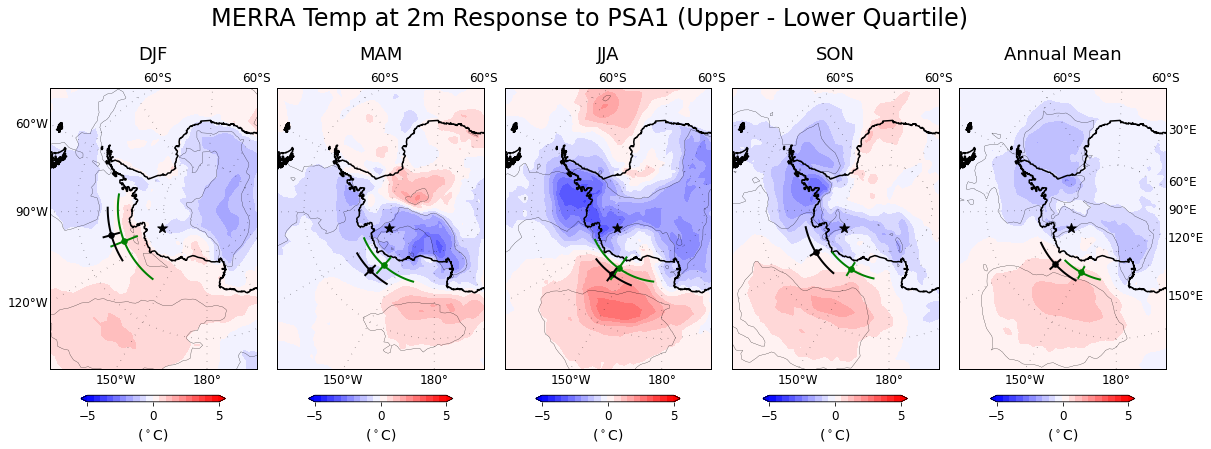

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('MERRA Temp at 2m Response to PSA1 (Upper - Lower Quartile)', fontsize=24, y=1.05)

# setup Lambert Conformal basemap.
diff_djf = djf_t2m_w_upper_PSA1_detrend_merra.mean(axis=0)-djf_t2m_w_lower_PSA1_detrend_merra.mean(axis=0)
diff_mam = mam_t2m_w_upper_PSA1_detrend_merra.mean(axis=0)-mam_t2m_w_lower_PSA1_detrend_merra.mean(axis=0)
diff_jja = jja_t2m_w_upper_PSA1_detrend_merra.mean(axis=0)-jja_t2m_w_lower_PSA1_detrend_merra.mean(axis=0)
diff_son = son_t2m_w_upper_PSA1_detrend_merra.mean(axis=0)-son_t2m_w_lower_PSA1_detrend_merra.mean(axis=0)
diff_ann = ann_mean_t2m_w_upper_PSA1_detrend_merra.mean(axis=0)-ann_mean_t2m_w_lower_PSA1_detrend_merra.mean(axis=0)
diff_djf_sh, lons = add_cyclic_point(diff_djf.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_mam_sh, lons = add_cyclic_point(diff_mam.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_jja_sh, lons = add_cyclic_point(diff_jja.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_son_sh, lons = add_cyclic_point(diff_son.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_ann_sh, lons = add_cyclic_point(diff_ann.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_djf_con, lons = add_cyclic_point(djf_t2m_change_due_to_PSA1_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)
diff_mam_con, lons = add_cyclic_point(mam_t2m_change_due_to_PSA1_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)
diff_jja_con, lons = add_cyclic_point(jja_t2m_change_due_to_PSA1_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)
diff_son_con, lons = add_cyclic_point(son_t2m_change_due_to_PSA1_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)
diff_ann_con, lons = add_cyclic_point(ann_mean_t2m_change_due_to_PSA1_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)

lon, lat = np.meshgrid(lons,MERRA_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-5,5.5,.5)
levels_contour = [-2.101,2.101] #good for seasons and annual mean

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(djf_t2m_w_upper_PSA1_detrend_merra.mean(axis=0)-djf_t2m_w_lower_PSA1_detrend_merra.mean(axis=0)).where((djf_t2m_change_due_to_PSA1_ttest_stats_merra >= levels_contour[1]) | (djf_t2m_change_due_to_PSA1_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
# CS = m.contourf(x,y,(djf_t2m_w_upper_PSA1_detrend_merra.mean(axis=0)-djf_t2m_w_lower_PSA1_detrend_merra.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_djf_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_djf_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.vals.mean(),djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(mam_t2m_w_upper_PSA1_detrend_merra.mean(axis=0)-mam_t2m_w_lower_PSA1_detrend_merra.mean(axis=0)).where((mam_t2m_change_due_to_PSA1_ttest_stats_merra >= levels_contour[1]) | (mam_t2m_change_due_to_PSA1_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_mam_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_mam_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean(),
            mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean(),
            mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()+mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()-mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()+mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()-mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()+mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()-mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()+mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()-mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.vals.mean(),mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.vals.mean())


#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(jja_t2m_w_upper_PSA1_detrend_merra.mean(axis=0)-jja_t2m_w_lower_PSA1_detrend_merra.mean(axis=0)).where((jja_t2m_change_due_to_PSA1_ttest_stats_merra >= levels_contour[1]) | (jja_t2m_change_due_to_PSA1_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_jja_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_jja_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.vals.mean(),jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.vals.mean())


#SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(son_t2m_w_upper_PSA1_detrend_merra.mean(axis=0)-son_t2m_w_lower_PSA1_detrend_merra.mean(axis=0)).where((son_t2m_change_due_to_PSA1_ttest_stats_merra >= levels_contour[1]) | (son_t2m_change_due_to_PSA1_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_son_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_son_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean(),
            son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean(),
            son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()+son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()-son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()+son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()-son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()+son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()-son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()+son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()-son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Rel_CP_indices_w_upper_PSA1_detrend_merra.vals.mean(),son_Rel_CP_indices_w_lower_PSA1_detrend_merra.vals.mean())


#Annual Mean
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(ann_mean_t2m_w_upper_PSA1_detrend_merra.mean(axis=0)-ann_mean_t2m_w_lower_PSA1_detrend_merra.mean(axis=0)).where((ann_mean_t2m_change_due_to_PSA1_ttest_stats_merra >= levels_contour[1]) | (ann_mean_t2m_change_due_to_PSA1_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_ann_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_ann_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.vals.mean(),ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.vals.mean())


# plt.savefig(FIG_PATH+'/Figure_MERRA_t2m_Field_vs_PSA1_Quartiles_01May2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

In [29]:
#Find PSA2 values for each of the 8 time periods and put in pd.DataFrame
#Then, select the upper and lower quartile values

d = {'PSA2': SAM_PSAs_seas_mean_indices_merra.PSA2.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '12').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.PSA2.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '12').dropna()),1)}
PSA2_djf_mean_merra = pd.DataFrame(data=d)
# PSA2_djf_mean_merra

d = {'PSA2': SAM_PSAs_seas_mean_indices_merra.PSA2.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '03').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.PSA2.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '03').dropna()),1)}
PSA2_mam_mean_merra = pd.DataFrame(data=d)
# PSA2_mam_mean_merra

d = {'PSA2': SAM_PSAs_seas_mean_indices_merra.PSA2.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '06').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.PSA2.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '06').dropna()),1)}
PSA2_jja_mean_merra = pd.DataFrame(data=d)
# PSA2_jja_mean_merra

d = {'PSA2': SAM_PSAs_seas_mean_indices_merra.PSA2.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '09').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.PSA2.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '09').dropna()),1)}
PSA2_son_mean_merra = pd.DataFrame(data=d)
# PSA2_son_mean_merra

d = {'PSA2': SAM_PSAs_ann_mean_indices_merra.PSA2.dropna(), 'indice': np.arange(0, len(SAM_PSAs_ann_mean_indices_merra.PSA2.dropna()),1)}
PSA2_ann_mean_merra = pd.DataFrame(data=d)
# PSA2_ann_mean_merra


#create list of indices representing the upper/lower quartiles of 'PSA2'
#Note, head is lower (sorted from low to high)
PSA2_djf_mean_lower_merra = PSA2_djf_mean_merra.sort_values(by=['PSA2']).head(n=(round(PSA2_djf_mean_merra.indice.size/4))).indice.tolist()
# PSA2_djf_mean_lower_merra
PSA2_djf_mean_upper_merra = PSA2_djf_mean_merra.sort_values(by=['PSA2']).tail(n=(round(PSA2_djf_mean_merra.indice.size/4))).indice.tolist()
# PSA2_djf_mean_upper_merra

PSA2_mam_mean_lower_merra = PSA2_mam_mean_merra.sort_values(by=['PSA2']).head(n=(round(PSA2_mam_mean_merra.indice.size/4))).indice.tolist()
# PSA2_mam_mean_lower_merra
PSA2_mam_mean_upper_merra = PSA2_mam_mean_merra.sort_values(by=['PSA2']).tail(n=(round(PSA2_mam_mean_merra.indice.size/4))).indice.tolist()
# PSA2_mam_mean_upper_merra

PSA2_jja_mean_lower_merra = PSA2_jja_mean_merra.sort_values(by=['PSA2']).head(n=(round(PSA2_jja_mean_merra.indice.size/4))).indice.tolist()
# PSA2_jja_mean_lower_merra
PSA2_jja_mean_upper_merra = PSA2_jja_mean_merra.sort_values(by=['PSA2']).tail(n=(round(PSA2_jja_mean_merra.indice.size/4))).indice.tolist()
# PSA2_jja_mean_upper_merra

PSA2_son_mean_lower_merra = PSA2_son_mean_merra.sort_values(by=['PSA2']).head(n=(round(PSA2_son_mean_merra.indice.size/4))).indice.tolist()
# PSA2_son_mean_lower_merra
PSA2_son_mean_upper_merra = PSA2_son_mean_merra.sort_values(by=['PSA2']).tail(n=(round(PSA2_son_mean_merra.indice.size/4))).indice.tolist()
# PSA2_son_mean_upper_merra

PSA2_ann_mean_lower_merra = PSA2_ann_mean_merra.sort_values(by=['PSA2']).head(n=(round(PSA2_ann_mean_merra.indice.size/4))).indice.tolist()
# PSA2_ann_mean_lower_merra
PSA2_ann_mean_upper_merra = PSA2_ann_mean_merra.sort_values(by=['PSA2']).tail(n=(round(PSA2_ann_mean_merra.indice.size/4))).indice.tolist()
# PSA2_ann_mean_upper_merra

In [30]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_t2m_w_upper_PSA2_detrend_merra = djf_t2m_shem_seas_mean_detrend_merra.isel(time = PSA2_djf_mean_upper_merra)
djf_t2m_w_lower_PSA2_detrend_merra = djf_t2m_shem_seas_mean_detrend_merra.isel(time = PSA2_djf_mean_lower_merra)
# djf_t2m_w_upper_PSA2_detrend_merra
# djf_t2m_w_lower_PSA2_detrend_merra

#mam
mam_t2m_w_upper_PSA2_detrend_merra = mam_t2m_shem_seas_mean_detrend_merra.isel(time = PSA2_mam_mean_upper_merra)
mam_t2m_w_lower_PSA2_detrend_merra = mam_t2m_shem_seas_mean_detrend_merra.isel(time = PSA2_mam_mean_lower_merra)
# mam_t2m_w_upper_PSA2_detrend_merra
# mam_t2m_w_lower_PSA2_detrend_merra

#jja
jja_t2m_w_upper_PSA2_detrend_merra = jja_t2m_shem_seas_mean_detrend_merra.isel(time = PSA2_jja_mean_upper_merra)
jja_t2m_w_lower_PSA2_detrend_merra = jja_t2m_shem_seas_mean_detrend_merra.isel(time = PSA2_jja_mean_lower_merra)
# jja_t2m_w_upper_PSA2_detrend_merra
# jja_t2m_w_lower_PSA2_detrend_merra

#son
son_t2m_w_upper_PSA2_detrend_merra = son_t2m_shem_seas_mean_detrend_merra.isel(time = PSA2_son_mean_upper_merra)
son_t2m_w_lower_PSA2_detrend_merra = son_t2m_shem_seas_mean_detrend_merra.isel(time = PSA2_son_mean_lower_merra)
son_t2m_w_upper_PSA2_detrend_merra
# son_t2m_w_lower_PSA2_detrend_merra

#ann mean
ann_mean_t2m_w_upper_PSA2_detrend_merra = t2m_shem_ann_mean_detrend_merra.isel(time = PSA2_ann_mean_upper_merra)
ann_mean_t2m_w_lower_PSA2_detrend_merra = t2m_shem_ann_mean_detrend_merra.isel(time = PSA2_ann_mean_lower_merra)
# ann_mean_t2m_w_upper_PSA2_detrend_merra
# ann_mean_t2m_w_lower_PSA2_detrend_merra


In [31]:
#Select ASL Rel CP value, long, and lat while index is in upper or lower quartile
#Using new ASL info from 19Nov2018
#djf
djf_Rel_CP_indices_w_upper_PSA2_detrend_merra = Rel_CP_djf_mean_indices_raw_merra.iloc[PSA2_djf_mean_upper_merra]
# djf_Rel_CP_indices_w_upper_PSA2_detrend_merra
djf_Rel_CP_indices_w_lower_PSA2_detrend_merra = Rel_CP_djf_mean_indices_raw_merra.iloc[PSA2_djf_mean_lower_merra]
# djf_Rel_CP_indices_w_lower_PSA2_detrend_merra

#mam
mam_Rel_CP_indices_w_upper_PSA2_detrend_merra = Rel_CP_mam_mean_indices_raw_merra.iloc[PSA2_mam_mean_upper_merra]
# mam_Rel_CP_indices_w_upper_PSA2_detrend_merra
mam_Rel_CP_indices_w_lower_PSA2_detrend_merra = Rel_CP_mam_mean_indices_raw_merra.iloc[PSA2_mam_mean_lower_merra]
# mam_Rel_CP_indices_w_lower_PSA2_detrend_merra

#jja
jja_Rel_CP_indices_w_upper_PSA2_detrend_merra = Rel_CP_jja_mean_indices_raw_merra.iloc[PSA2_jja_mean_upper_merra]
# jja_Rel_CP_indices_w_upper_PSA2_detrend_merra
jja_Rel_CP_indices_w_lower_PSA2_detrend_merra = Rel_CP_jja_mean_indices_raw_merra.iloc[PSA2_jja_mean_lower_merra]
# jja_Rel_CP_indices_w_lower_PSA2_detrend_merra

#son
son_Rel_CP_indices_w_upper_PSA2_detrend_merra = Rel_CP_son_mean_indices_raw_merra.iloc[PSA2_son_mean_upper_merra]
# son_Rel_CP_indices_w_upper_PSA2_detrend_merra
son_Rel_CP_indices_w_lower_PSA2_detrend_merra = Rel_CP_son_mean_indices_raw_merra.iloc[PSA2_son_mean_lower_merra]
# son_Rel_CP_indices_w_lower_PSA2_detrend_merra

#annual mean
ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra = Rel_CP_ann_mean_indices_raw_merra.iloc[PSA2_ann_mean_upper_merra]
# ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra
ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra = Rel_CP_ann_mean_indices_raw_merra.iloc[PSA2_ann_mean_lower_merra]
# ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra



In [32]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#Seasonal and ann mean, df=19+19-2 = 36 ; critical value = +- 2.028
#DJF, df =18+18-2 = 34 ; critical value = +- 2.032 (so close to df=36 that I am not going to change)

djf_t2m_change_due_to_PSA2_ttest_stats_merra, djf_t2m_change_due_to_PSA2_ttest_pvals_merra = ttest_ind(
    djf_t2m_w_upper_PSA2_detrend_merra, djf_t2m_w_lower_PSA2_detrend_merra, axis=0)

mam_t2m_change_due_to_PSA2_ttest_stats_merra, mam_t2m_change_due_to_PSA2_ttest_pvals_merra = ttest_ind(
    mam_t2m_w_upper_PSA2_detrend_merra, mam_t2m_w_lower_PSA2_detrend_merra, axis=0)

jja_t2m_change_due_to_PSA2_ttest_stats_merra, jja_t2m_change_due_to_PSA2_ttest_pvals_merra = ttest_ind(
    jja_t2m_w_upper_PSA2_detrend_merra, jja_t2m_w_lower_PSA2_detrend_merra, axis=0)

son_t2m_change_due_to_PSA2_ttest_stats_merra, son_t2m_change_due_to_PSA2_ttest_pvals_merra = ttest_ind(
    son_t2m_w_upper_PSA2_detrend_merra, son_t2m_w_lower_PSA2_detrend_merra, axis=0)

ann_mean_t2m_change_due_to_PSA2_ttest_stats_merra, ann_mean_t2m_change_due_to_PSA2_ttest_pvals_merra = ttest_ind(
    ann_mean_t2m_w_upper_PSA2_detrend_merra, ann_mean_t2m_w_lower_PSA2_detrend_merra, axis=0)

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-6.805188966140829 -5.078415975272542


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-7.497449203490282 -8.170160944265069


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-7.791644566281081 -8.706484988630962


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-8.150771631953955 -8.086319907587688


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:351: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-5.434098196360674 -5.81004511551555


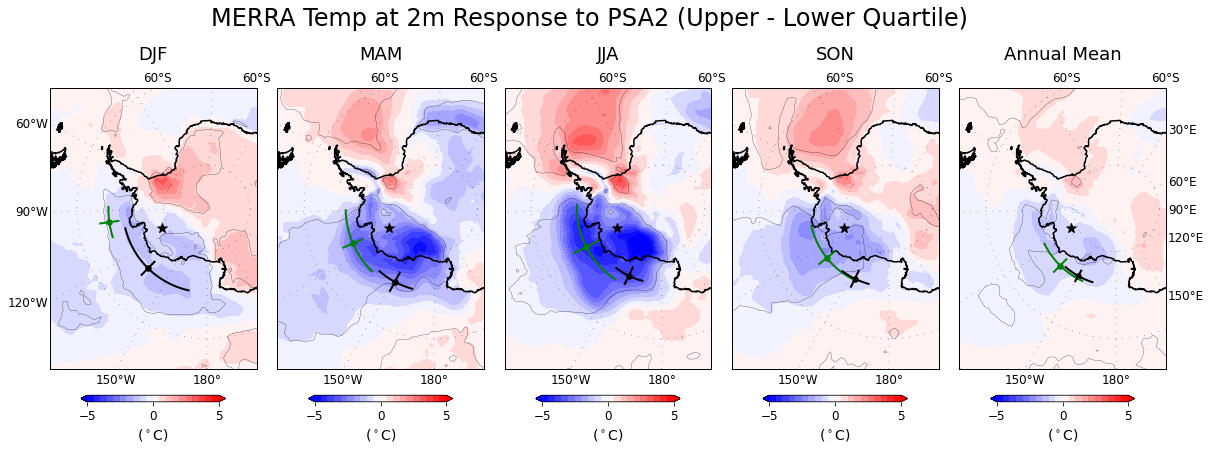

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('MERRA Temp at 2m Response to PSA2 (Upper - Lower Quartile)', fontsize=24, y=1.05)

# setup Lambert Conformal basemap.
diff_djf = djf_t2m_w_upper_PSA2_detrend_merra.mean(axis=0)-djf_t2m_w_lower_PSA2_detrend_merra.mean(axis=0)
diff_mam = mam_t2m_w_upper_PSA2_detrend_merra.mean(axis=0)-mam_t2m_w_lower_PSA2_detrend_merra.mean(axis=0)
diff_jja = jja_t2m_w_upper_PSA2_detrend_merra.mean(axis=0)-jja_t2m_w_lower_PSA2_detrend_merra.mean(axis=0)
diff_son = son_t2m_w_upper_PSA2_detrend_merra.mean(axis=0)-son_t2m_w_lower_PSA2_detrend_merra.mean(axis=0)
diff_ann = ann_mean_t2m_w_upper_PSA2_detrend_merra.mean(axis=0)-ann_mean_t2m_w_lower_PSA2_detrend_merra.mean(axis=0)
diff_djf_sh, lons = add_cyclic_point(diff_djf.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_mam_sh, lons = add_cyclic_point(diff_mam.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_jja_sh, lons = add_cyclic_point(diff_jja.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_son_sh, lons = add_cyclic_point(diff_son.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_ann_sh, lons = add_cyclic_point(diff_ann.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_djf_con, lons = add_cyclic_point(djf_t2m_change_due_to_PSA2_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)
diff_mam_con, lons = add_cyclic_point(mam_t2m_change_due_to_PSA2_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)
diff_jja_con, lons = add_cyclic_point(jja_t2m_change_due_to_PSA2_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)
diff_son_con, lons = add_cyclic_point(son_t2m_change_due_to_PSA2_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)
diff_ann_con, lons = add_cyclic_point(ann_mean_t2m_change_due_to_PSA2_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)

lon, lat = np.meshgrid(lons,MERRA_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-5,5.5,.5)
levels_contour = [-2.101,2.101] #good for seasons and annual mean

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(djf_t2m_w_upper_PSA2_detrend_merra.mean(axis=0)-djf_t2m_w_lower_PSA2_detrend_merra.mean(axis=0)).where((djf_t2m_change_due_to_PSA2_ttest_stats_merra >= levels_contour[1]) | (djf_t2m_change_due_to_PSA2_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
# CS = m.contourf(x,y,(djf_t2m_w_upper_PSA2_detrend_merra.mean(axis=0)-djf_t2m_w_lower_PSA2_detrend_merra.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_djf_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_djf_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.vals.mean(),djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(mam_t2m_w_upper_PSA2_detrend_merra.mean(axis=0)-mam_t2m_w_lower_PSA2_detrend_merra.mean(axis=0)).where((mam_t2m_change_due_to_PSA2_ttest_stats_merra >= levels_contour[1]) | (mam_t2m_change_due_to_PSA2_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_mam_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_mam_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean(),
            mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean(),
            mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()+mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()-mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()+mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()-mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()+mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()-mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()+mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()-mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.vals.mean(),mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.vals.mean())


#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(jja_t2m_w_upper_PSA2_detrend_merra.mean(axis=0)-jja_t2m_w_lower_PSA2_detrend_merra.mean(axis=0)).where((jja_t2m_change_due_to_PSA2_ttest_stats_merra >= levels_contour[1]) | (jja_t2m_change_due_to_PSA2_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_jja_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_jja_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.vals.mean(),jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.vals.mean())


#SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(son_t2m_w_upper_PSA2_detrend_merra.mean(axis=0)-son_t2m_w_lower_PSA2_detrend_merra.mean(axis=0)).where((son_t2m_change_due_to_PSA2_ttest_stats_merra >= levels_contour[1]) | (son_t2m_change_due_to_PSA2_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_son_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_son_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean(),
            son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean(),
            son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()+son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()-son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()+son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()-son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()+son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()-son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()+son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()-son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Rel_CP_indices_w_upper_PSA2_detrend_merra.vals.mean(),son_Rel_CP_indices_w_lower_PSA2_detrend_merra.vals.mean())


#Annual Mean
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(ann_mean_t2m_w_upper_PSA2_detrend_merra.mean(axis=0)-ann_mean_t2m_w_lower_PSA2_detrend_merra.mean(axis=0)).where((ann_mean_t2m_change_due_to_PSA2_ttest_stats_merra >= levels_contour[1]) | (ann_mean_t2m_change_due_to_PSA2_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_ann_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_ann_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.vals.mean(),ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.vals.mean())


# plt.savefig(FIG_PATH+'/Figure_MERRA_t2m_Field_vs_PSA2_Quartiles_01May2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

In [34]:
#It would be good to use Long Upper Quart vs Lower Quart and Rel CP Upper Quart vs Lower Quart; this would 
#allow a tie to Hoskings et al and confirm my previous work

#West most is the lower quartile (west has lower long values which range from 0 to 360)
#East most is the upper quartile (east has higher long values which range from 0 to 360)

In [35]:
#create list of indices representing the eastmost/westmost quartiles of 'lons'
#Note, head is westmost (sorted from low to high)
lons_djf_mean_westmost_merra = Rel_CP_djf_mean_indices_raw_merra.sort_values(by=['lons']).head(n=(round(Rel_CP_djf_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(lons_djf_mean_westmost_merra)
lons_djf_mean_eastmost_merra = Rel_CP_djf_mean_indices_raw_merra.sort_values(by=['lons']).tail(n=(round(Rel_CP_djf_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(lons_djf_mean_eastmost_merra)

lons_mam_mean_westmost_merra = Rel_CP_mam_mean_indices_raw_merra.sort_values(by=['lons']).head(n=(round(Rel_CP_mam_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(lons_mam_mean_westmost_merra)
lons_mam_mean_eastmost_merra = Rel_CP_mam_mean_indices_raw_merra.sort_values(by=['lons']).tail(n=(round(Rel_CP_mam_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(lons_mam_mean_eastmost_merra)

lons_jja_mean_westmost_merra = Rel_CP_jja_mean_indices_raw_merra.sort_values(by=['lons']).head(n=(round(Rel_CP_jja_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(lons_jja_mean_westmost_merra)
lons_jja_mean_eastmost_merra = Rel_CP_jja_mean_indices_raw_merra.sort_values(by=['lons']).tail(n=(round(Rel_CP_jja_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(lons_jja_mean_eastmost_merra)

lons_son_mean_westmost_merra = Rel_CP_son_mean_indices_raw_merra.sort_values(by=['lons']).head(n=(round(Rel_CP_son_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(lons_son_mean_westmost_merra)
lons_son_mean_eastmost_merra = Rel_CP_son_mean_indices_raw_merra.sort_values(by=['lons']).tail(n=(round(Rel_CP_son_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(lons_son_mean_eastmost_merra)

lons_ann_mean_westmost_merra = Rel_CP_ann_mean_indices_raw_merra.sort_values(by=['lons']).head(n=(round(Rel_CP_ann_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(lons_ann_mean_westmost_merra)
lons_ann_mean_eastmost_merra = Rel_CP_ann_mean_indices_raw_merra.sort_values(by=['lons']).tail(n=(round(Rel_CP_ann_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(lons_ann_mean_eastmost_merra)

[17, 14, 36, 33, 26, 32, 35, 9, 25]
[29, 10, 28, 0, 31, 11, 24, 2, 20]
[6, 0, 12, 22, 11, 4, 14, 23, 17, 18]
[16, 28, 19, 34, 29, 7, 15, 26, 31, 2]
[7, 8, 37, 13, 16, 15, 2, 25, 17, 11]
[3, 9, 30, 36, 32, 1, 23, 10, 33, 6]
[13, 23, 32, 22, 4, 17, 14, 3, 11, 29]
[37, 9, 33, 0, 36, 30, 27, 16, 7, 1]
[17, 12, 22, 14, 15, 7, 11, 2, 0, 13]
[21, 19, 9, 28, 24, 33, 3, 30, 16, 10]


In [36]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_t2m_w_eastmost_lons_detrend_merra = djf_t2m_shem_seas_mean_detrend_merra.isel(time = lons_djf_mean_eastmost_merra)
djf_t2m_w_westmost_lons_detrend_merra = djf_t2m_shem_seas_mean_detrend_merra.isel(time = lons_djf_mean_westmost_merra)
# djf_t2m_w_eastmost_lons_detrend_merra
# djf_t2m_w_westmost_lons_detrend_merra

#mam
mam_t2m_w_eastmost_lons_detrend_merra = mam_t2m_shem_seas_mean_detrend_merra.isel(time = lons_mam_mean_eastmost_merra)
mam_t2m_w_westmost_lons_detrend_merra = mam_t2m_shem_seas_mean_detrend_merra.isel(time = lons_mam_mean_westmost_merra)
# mam_t2m_w_eastmost_lons_detrend_merra
# mam_t2m_w_westmost_lons_detrend_merra

#jja
jja_t2m_w_eastmost_lons_detrend_merra = jja_t2m_shem_seas_mean_detrend_merra.isel(time = lons_jja_mean_eastmost_merra)
jja_t2m_w_westmost_lons_detrend_merra = jja_t2m_shem_seas_mean_detrend_merra.isel(time = lons_jja_mean_westmost_merra)
# jja_t2m_w_eastmost_lons_detrend_merra
# jja_t2m_w_westmost_lons_detrend_merra

#son
son_t2m_w_eastmost_lons_detrend_merra = son_t2m_shem_seas_mean_detrend_merra.isel(time = lons_son_mean_eastmost_merra)
son_t2m_w_westmost_lons_detrend_merra = son_t2m_shem_seas_mean_detrend_merra.isel(time = lons_son_mean_westmost_merra)
son_t2m_w_eastmost_lons_detrend_merra
# son_t2m_w_westmost_lons_detrend_merra

#ann mean
ann_mean_t2m_w_eastmost_lons_detrend_merra = t2m_shem_ann_mean_detrend_merra.isel(time = lons_ann_mean_eastmost_merra)
ann_mean_t2m_w_westmost_lons_detrend_merra = t2m_shem_ann_mean_detrend_merra.isel(time = lons_ann_mean_westmost_merra)
# ann_mean_t2m_w_eastmost_lons_detrend_merra
# ann_mean_t2m_w_westmost_lons_detrend_merra


In [37]:
#Select ASL Rel CP value, long, and lat while ASL Lons is in upper (eastmost) or lower (westmost) quartile
#Using new ASL info from 19Nov2018

#djf
djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra = Rel_CP_djf_mean_indices_raw_merra.iloc[lons_djf_mean_eastmost_merra]
# djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra
djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra = Rel_CP_djf_mean_indices_raw_merra.iloc[lons_djf_mean_westmost_merra]
# djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra

#mam
mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra = Rel_CP_mam_mean_indices_raw_merra.iloc[lons_mam_mean_eastmost_merra]
# mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra
mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra = Rel_CP_mam_mean_indices_raw_merra.iloc[lons_mam_mean_westmost_merra]
# mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra

#jja
jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra = Rel_CP_jja_mean_indices_raw_merra.iloc[lons_jja_mean_eastmost_merra]
# jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra
jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra = Rel_CP_jja_mean_indices_raw_merra.iloc[lons_jja_mean_westmost_merra]
# jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra

#son
son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra = Rel_CP_son_mean_indices_raw_merra.iloc[lons_son_mean_eastmost_merra]
# son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra
son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra = Rel_CP_son_mean_indices_raw_merra.iloc[lons_son_mean_westmost_merra]
# son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra

#annual mean
ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra = Rel_CP_ann_mean_indices_raw_merra.iloc[lons_ann_mean_eastmost_merra]
# ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra
ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra = Rel_CP_ann_mean_indices_raw_merra.iloc[lons_ann_mean_westmost_merra]
# ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra

In [38]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#Seasonal and ann mean, df=19+19-2 = 36 ; critical value = +- 2.028
#DJF, df =18+18-2 = 34 ; critical value = +- 2.032 (so close to df=36 that I am not going to change)

djf_t2m_change_due_to_lons_ttest_stats_merra, djf_t2m_change_due_to_lons_ttest_pvals_merra = ttest_ind(
    djf_t2m_w_eastmost_lons_detrend_merra, djf_t2m_w_westmost_lons_detrend_merra, axis=0)

mam_t2m_change_due_to_lons_ttest_stats_merra, mam_t2m_change_due_to_lons_ttest_pvals_merra = ttest_ind(
    mam_t2m_w_eastmost_lons_detrend_merra, mam_t2m_w_westmost_lons_detrend_merra, axis=0)

jja_t2m_change_due_to_lons_ttest_stats_merra, jja_t2m_change_due_to_lons_ttest_pvals_merra = ttest_ind(
    jja_t2m_w_eastmost_lons_detrend_merra, jja_t2m_w_westmost_lons_detrend_merra, axis=0)

son_t2m_change_due_to_lons_ttest_stats_merra, son_t2m_change_due_to_lons_ttest_pvals_merra = ttest_ind(
    son_t2m_w_eastmost_lons_detrend_merra, son_t2m_w_westmost_lons_detrend_merra, axis=0)

ann_mean_t2m_change_due_to_lons_ttest_stats_merra, ann_mean_t2m_change_due_to_lons_ttest_pvals_merra = ttest_ind(
    ann_mean_t2m_w_eastmost_lons_detrend_merra, ann_mean_t2m_w_westmost_lons_detrend_merra, axis=0)

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-4.4683770841464066 -5.463905130802522


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-7.701090626390237 -7.344735197294062


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-9.69268567045558 -7.973148941063698


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:271: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-7.525103754718759 -7.1589333335202925
-5.552982454547555 -5.758203179819759


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:350: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


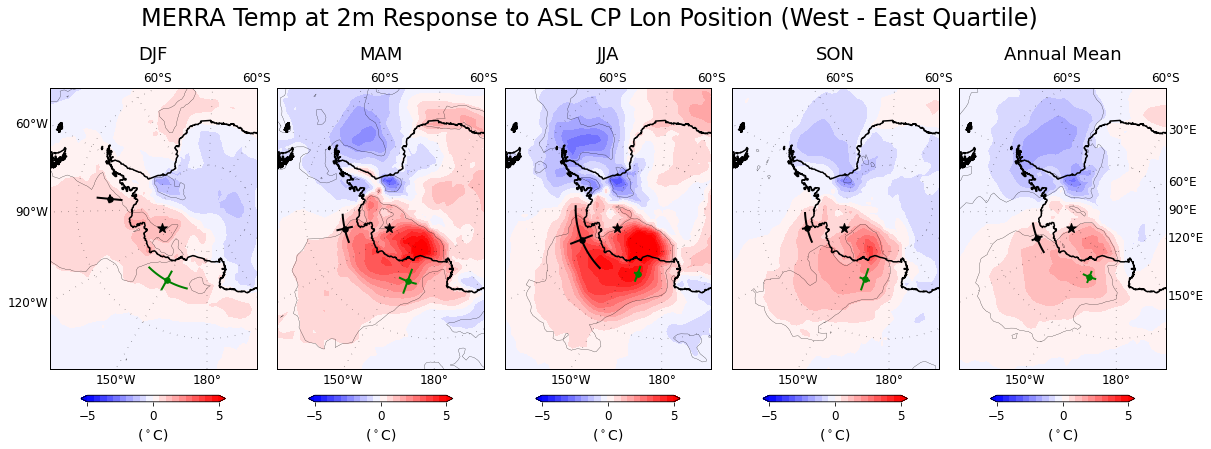

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('MERRA Temp at 2m Response to ASL CP Lon Position (West - East Quartile)', fontsize=24, y=1.05)

# setup Lambert Conformal basemap.
diff_djf = djf_t2m_w_westmost_lons_detrend_merra.mean(axis=0)-djf_t2m_w_eastmost_lons_detrend_merra.mean(axis=0)
diff_mam = mam_t2m_w_westmost_lons_detrend_merra.mean(axis=0)-mam_t2m_w_eastmost_lons_detrend_merra.mean(axis=0)
diff_jja = jja_t2m_w_westmost_lons_detrend_merra.mean(axis=0)-jja_t2m_w_eastmost_lons_detrend_merra.mean(axis=0)
diff_son = son_t2m_w_westmost_lons_detrend_merra.mean(axis=0)-son_t2m_w_eastmost_lons_detrend_merra.mean(axis=0)
diff_ann = ann_mean_t2m_w_westmost_lons_detrend_merra.mean(axis=0)-ann_mean_t2m_w_eastmost_lons_detrend_merra.mean(axis=0)
diff_djf_sh, lons = add_cyclic_point(diff_djf.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_mam_sh, lons = add_cyclic_point(diff_mam.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_jja_sh, lons = add_cyclic_point(diff_jja.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_son_sh, lons = add_cyclic_point(diff_son.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_ann_sh, lons = add_cyclic_point(diff_ann.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_djf_con, lons = add_cyclic_point(djf_t2m_change_due_to_lons_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)
diff_mam_con, lons = add_cyclic_point(mam_t2m_change_due_to_lons_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)
diff_jja_con, lons = add_cyclic_point(jja_t2m_change_due_to_lons_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)
diff_son_con, lons = add_cyclic_point(son_t2m_change_due_to_lons_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)
diff_ann_con, lons = add_cyclic_point(ann_mean_t2m_change_due_to_lons_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)

lon, lat = np.meshgrid(lons,MERRA_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-5,5.5,.5)
levels_contour = [-2.101,2.101] #good for seasons and annual mean

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(djf_t2m_w_westmost_lons_detrend_merra.mean(axis=0)-djf_t2m_w_eastmost_lons_detrend_merra.mean(axis=0)).where((djf_t2m_change_due_to_lons_ttest_stats_merra >= levels_contour[1]) | (djf_t2m_change_due_to_lons_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_djf_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_djf_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for westmost and eastmost indice
#westmost
xpt,ypt = m(djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#eastmost
xpt,ypt = m(djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#westmost
lat_line = np.linspace(djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#eastmost
lat_line = np.linspace(djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.vals.mean(),djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(mam_t2m_w_westmost_lons_detrend_merra.mean(axis=0)-mam_t2m_w_eastmost_lons_detrend_merra.mean(axis=0)).where((mam_t2m_change_due_to_lons_ttest_stats_merra >= levels_contour[1]) | (mam_t2m_change_due_to_lons_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_mam_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_mam_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for westmost and eastmost indice
#westmost
xpt,ypt = m(mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.mean(),
            mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#eastmost
xpt,ypt = m(mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.mean(),
            mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#westmost
lat_line = np.linspace(mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.mean()
                       ,mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.mean()+mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.std()
                       ,mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.mean()-mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.mean()+mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.std()
                       ,mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.mean()-mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.mean()
                       ,mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#eastmost
lat_line = np.linspace(mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.mean()
                       ,mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.mean()+mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.std()
                       ,mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.mean()-mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.mean()+mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.std()
                       ,mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.mean()-mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.mean()
                       ,mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.vals.mean(),mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.vals.mean())


#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(jja_t2m_w_westmost_lons_detrend_merra.mean(axis=0)-jja_t2m_w_eastmost_lons_detrend_merra.mean(axis=0)).where((jja_t2m_change_due_to_lons_ttest_stats_merra >= levels_contour[1]) | (jja_t2m_change_due_to_lons_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_jja_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_jja_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for westmost and eastmost indice
#westmost
xpt,ypt = m(jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#eastmost
xpt,ypt = m(jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#westmost
lat_line = np.linspace(jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#eastmost
lat_line = np.linspace(jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.vals.mean(),jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.vals.mean())


#SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(son_t2m_w_westmost_lons_detrend_merra.mean(axis=0)-son_t2m_w_eastmost_lons_detrend_merra.mean(axis=0)).where((son_t2m_change_due_to_lons_ttest_stats_merra >= levels_contour[1]) | (son_t2m_change_due_to_lons_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_son_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_son_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for westmost and eastmost indice
#westmost
xpt,ypt = m(son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.mean(),
            son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#eastmost
xpt,ypt = m(son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.mean(),
            son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#westmost
lat_line = np.linspace(son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.mean()
                       ,son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.mean()+son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.std()
                       ,son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.mean()-son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.mean()+son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.std()
                       ,son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.mean()-son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.mean()
                       ,son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#eastmost
lat_line = np.linspace(son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.mean()
                       ,son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.mean()+son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.std()
                       ,son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.mean()-son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.mean()+son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.std()
                       ,son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.mean()-son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.mean()
                       ,son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.vals.mean(),son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.vals.mean())


#Annual Mean
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(ann_mean_t2m_w_westmost_lons_detrend_merra.mean(axis=0)-ann_mean_t2m_w_eastmost_lons_detrend_merra.mean(axis=0)).where((ann_mean_t2m_change_due_to_lons_ttest_stats_merra >= levels_contour[1]) | (ann_mean_t2m_change_due_to_lons_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_ann_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_ann_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for westmost and eastmost indice
#westmost
xpt,ypt = m(ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#eastmost
xpt,ypt = m(ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#westmost
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#eastmost
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
#plt.annotate('Jul-24-2012', xy=(0, 1), xycoords='axes fraction')
print(ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_merra.vals.mean(),ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_merra.vals.mean())


# plt.savefig(FIG_PATH+'/Figure_MERRA_t2m_Field_vs_ASL_CP_Lon_Position_Quartiles_01May2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

In [40]:
#Relative CP Minimum Pressure Upper Quart vs Lower Quart; this would allow a tie to Hoskings et al and confirm my previous work

#Deep most is the lower quartile (deep has lower Rel CP values)
#Shallow most is the upper quartile (shallow has higher Rel CP values)

In [41]:
#create list of indices representing the shallowmost/deepmost quartiles of 'vals'
#Note, head is deepmost (sorted from low to high)
rel_cp_djf_mean_deepmost_merra = Rel_CP_djf_mean_indices_raw_merra.sort_values(by=['vals']).head(n=(round(Rel_CP_djf_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(rel_cp_djf_mean_deepmost_merra)
rel_cp_djf_mean_shallowmost_merra = Rel_CP_djf_mean_indices_raw_merra.sort_values(by=['vals']).tail(n=(round(Rel_CP_djf_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(rel_cp_djf_mean_shallowmost_merra)

rel_cp_mam_mean_deepmost_merra = Rel_CP_mam_mean_indices_raw_merra.sort_values(by=['vals']).head(n=(round(Rel_CP_mam_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(rel_cp_mam_mean_deepmost_merra)
rel_cp_mam_mean_shallowmost_merra = Rel_CP_mam_mean_indices_raw_merra.sort_values(by=['vals']).tail(n=(round(Rel_CP_mam_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(rel_cp_mam_mean_shallowmost_merra)

rel_cp_jja_mean_deepmost_merra = Rel_CP_jja_mean_indices_raw_merra.sort_values(by=['vals']).head(n=(round(Rel_CP_jja_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(rel_cp_jja_mean_deepmost_merra)
rel_cp_jja_mean_shallowmost_merra = Rel_CP_jja_mean_indices_raw_merra.sort_values(by=['vals']).tail(n=(round(Rel_CP_jja_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(rel_cp_jja_mean_shallowmost_merra)

rel_cp_son_mean_deepmost_merra = Rel_CP_son_mean_indices_raw_merra.sort_values(by=['vals']).head(n=(round(Rel_CP_son_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(rel_cp_son_mean_deepmost_merra)
rel_cp_son_mean_shallowmost_merra = Rel_CP_son_mean_indices_raw_merra.sort_values(by=['vals']).tail(n=(round(Rel_CP_son_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(rel_cp_son_mean_shallowmost_merra)

rel_cp_ann_mean_deepmost_merra = Rel_CP_ann_mean_indices_raw_merra.sort_values(by=['vals']).head(n=(round(Rel_CP_ann_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(rel_cp_ann_mean_deepmost_merra)
rel_cp_ann_mean_shallowmost_merra = Rel_CP_ann_mean_indices_raw_merra.sort_values(by=['vals']).tail(n=(round(Rel_CP_ann_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(rel_cp_ann_mean_shallowmost_merra)

[21, 2, 18, 34, 22, 15, 5, 6, 3]
[9, 25, 14, 12, 24, 36, 32, 17, 29]
[26, 2, 23, 22, 17, 36, 11, 37, 3, 18]
[4, 32, 27, 25, 0, 20, 6, 7, 31, 10]
[7, 25, 2, 10, 8, 17, 6, 30, 13, 24]
[33, 31, 3, 22, 12, 27, 19, 36, 29, 14]
[25, 17, 30, 21, 28, 6, 16, 5, 11, 23]
[0, 33, 24, 18, 1, 34, 10, 26, 27, 22]
[11, 17, 25, 30, 5, 28, 35, 9, 18, 13]
[12, 1, 32, 31, 10, 33, 7, 26, 0, 29]


In [42]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_t2m_w_shallowmost_rel_cp_detrend_merra = djf_t2m_shem_seas_mean_detrend_merra.isel(time = rel_cp_djf_mean_shallowmost_merra)
djf_t2m_w_deepmost_rel_cp_detrend_merra = djf_t2m_shem_seas_mean_detrend_merra.isel(time = rel_cp_djf_mean_deepmost_merra)
# djf_t2m_w_shallowmost_rel_cp_detrend_merra
# djf_t2m_w_deepmost_rel_cp_detrend_merra

#mam
mam_t2m_w_shallowmost_rel_cp_detrend_merra = mam_t2m_shem_seas_mean_detrend_merra.isel(time = rel_cp_mam_mean_shallowmost_merra)
mam_t2m_w_deepmost_rel_cp_detrend_merra = mam_t2m_shem_seas_mean_detrend_merra.isel(time = rel_cp_mam_mean_deepmost_merra)
# mam_t2m_w_shallowmost_rel_cp_detrend_merra
# mam_t2m_w_deepmost_rel_cp_detrend_merra

#jja
jja_t2m_w_shallowmost_rel_cp_detrend_merra = jja_t2m_shem_seas_mean_detrend_merra.isel(time = rel_cp_jja_mean_shallowmost_merra)
jja_t2m_w_deepmost_rel_cp_detrend_merra = jja_t2m_shem_seas_mean_detrend_merra.isel(time = rel_cp_jja_mean_deepmost_merra)
# jja_t2m_w_shallowmost_rel_cp_detrend_merra
# jja_t2m_w_deepmost_rel_cp_detrend_merra

#son
son_t2m_w_shallowmost_rel_cp_detrend_merra = son_t2m_shem_seas_mean_detrend_merra.isel(time = rel_cp_son_mean_shallowmost_merra)
son_t2m_w_deepmost_rel_cp_detrend_merra = son_t2m_shem_seas_mean_detrend_merra.isel(time = rel_cp_son_mean_deepmost_merra)
son_t2m_w_shallowmost_rel_cp_detrend_merra
# son_t2m_w_deepmost_rel_cp_detrend_merra

#ann mean
ann_mean_t2m_w_shallowmost_rel_cp_detrend_merra = t2m_shem_ann_mean_detrend_merra.isel(time = rel_cp_ann_mean_shallowmost_merra)
ann_mean_t2m_w_deepmost_rel_cp_detrend_merra = t2m_shem_ann_mean_detrend_merra.isel(time = rel_cp_ann_mean_deepmost_merra)
# ann_mean_t2m_w_shallowmost_rel_cp_detrend_merra
# ann_mean_t2m_w_deepmost_rel_cp_detrend_merra


In [43]:
#Select ASL Rel CP value, long, and lat while ASL Rel CP is in shallowmost or deepmost quartile
#Using new ASL info from 19Nov2018

#djf
djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra = Rel_CP_djf_mean_indices_raw_merra.iloc[rel_cp_djf_mean_shallowmost_merra]
# djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra
djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra = Rel_CP_djf_mean_indices_raw_merra.iloc[rel_cp_djf_mean_deepmost_merra]
# djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra

#mam
mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra = Rel_CP_mam_mean_indices_raw_merra.iloc[rel_cp_mam_mean_shallowmost_merra]
# mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra
mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra = Rel_CP_mam_mean_indices_raw_merra.iloc[rel_cp_mam_mean_deepmost_merra]
# mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra

#jja
jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra = Rel_CP_jja_mean_indices_raw_merra.iloc[rel_cp_jja_mean_shallowmost_merra]
# jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra
jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra = Rel_CP_jja_mean_indices_raw_merra.iloc[rel_cp_jja_mean_deepmost_merra]
# jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra

#son
son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra = Rel_CP_son_mean_indices_raw_merra.iloc[rel_cp_son_mean_shallowmost_merra]
# son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra
son_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra = Rel_CP_son_mean_indices_raw_merra.iloc[rel_cp_son_mean_deepmost_merra]
# son_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra

#annual mean
ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra = Rel_CP_ann_mean_indices_raw_merra.iloc[rel_cp_ann_mean_shallowmost_merra]
# ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra
ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra = Rel_CP_ann_mean_indices_raw_merra.iloc[rel_cp_ann_mean_deepmost_merra]
# ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra

In [44]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#Seasonal and ann mean, df=19+19-2 = 36 ; critical value = +- 2.028
#DJF, df =18+18-2 = 34 ; critical value = +- 2.032 (so close to df=36 that I am not going to change)

djf_t2m_change_due_to_rel_cp_ttest_stats_merra, djf_t2m_change_due_to_rel_cp_ttest_pvals_merra = ttest_ind(
    djf_t2m_w_shallowmost_rel_cp_detrend_merra, djf_t2m_w_deepmost_rel_cp_detrend_merra, axis=0)

mam_t2m_change_due_to_rel_cp_ttest_stats_merra, mam_t2m_change_due_to_rel_cp_ttest_pvals_merra = ttest_ind(
    mam_t2m_w_shallowmost_rel_cp_detrend_merra, mam_t2m_w_deepmost_rel_cp_detrend_merra, axis=0)

jja_t2m_change_due_to_rel_cp_ttest_stats_merra, jja_t2m_change_due_to_rel_cp_ttest_pvals_merra = ttest_ind(
    jja_t2m_w_shallowmost_rel_cp_detrend_merra, jja_t2m_w_deepmost_rel_cp_detrend_merra, axis=0)

son_t2m_change_due_to_rel_cp_ttest_stats_merra, son_t2m_change_due_to_rel_cp_ttest_pvals_merra = ttest_ind(
    son_t2m_w_shallowmost_rel_cp_detrend_merra, son_t2m_w_deepmost_rel_cp_detrend_merra, axis=0)

ann_mean_t2m_change_due_to_rel_cp_ttest_stats_merra, ann_mean_t2m_change_due_to_rel_cp_ttest_pvals_merra = ttest_ind(
    ann_mean_t2m_w_shallowmost_rel_cp_detrend_merra, ann_mean_t2m_w_deepmost_rel_cp_detrend_merra, axis=0)

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-7.246562224741335 -3.9421248459716356


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-9.107867733415901 -5.302909122533253


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-10.258743205671351 -5.8186834196191395


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:271: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-9.6457153633791 -5.393586074880659
-6.478115576357766 -4.690441584767177


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:350: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


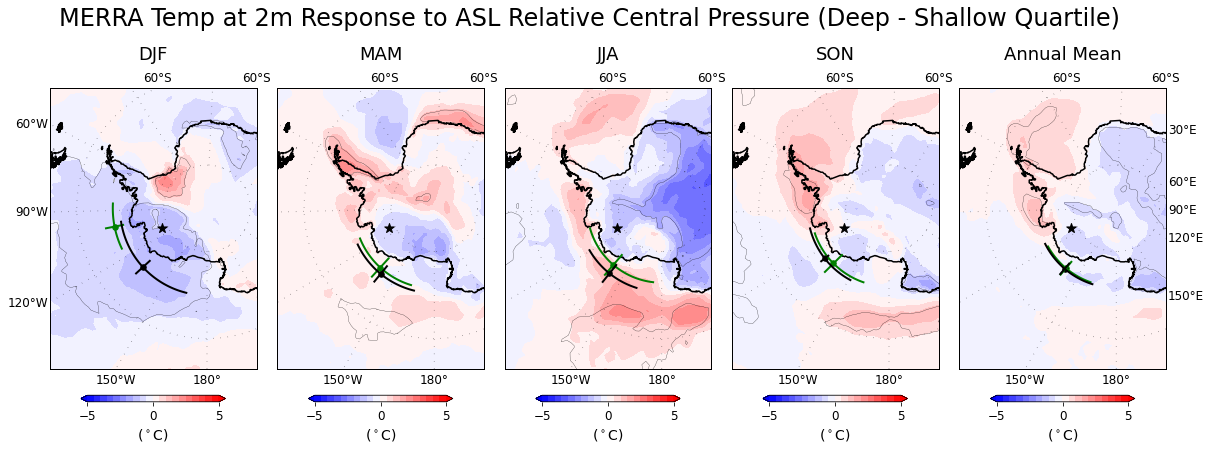

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('MERRA Temp at 2m Response to ASL Relative Central Pressure (Deep - Shallow Quartile)', fontsize=24, y=1.05)

# setup Lambert Conformal basemap.
diff_djf = djf_t2m_w_deepmost_rel_cp_detrend_merra.mean(axis=0)-djf_t2m_w_shallowmost_rel_cp_detrend_merra.mean(axis=0)
diff_mam = mam_t2m_w_deepmost_rel_cp_detrend_merra.mean(axis=0)-mam_t2m_w_shallowmost_rel_cp_detrend_merra.mean(axis=0)
diff_jja = jja_t2m_w_deepmost_rel_cp_detrend_merra.mean(axis=0)-jja_t2m_w_shallowmost_rel_cp_detrend_merra.mean(axis=0)
diff_son = son_t2m_w_deepmost_rel_cp_detrend_merra.mean(axis=0)-son_t2m_w_shallowmost_rel_cp_detrend_merra.mean(axis=0)
diff_ann = ann_mean_t2m_w_deepmost_rel_cp_detrend_merra.mean(axis=0)-ann_mean_t2m_w_shallowmost_rel_cp_detrend_merra.mean(axis=0)
diff_djf_sh, lons = add_cyclic_point(diff_djf.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_mam_sh, lons = add_cyclic_point(diff_mam.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_jja_sh, lons = add_cyclic_point(diff_jja.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_son_sh, lons = add_cyclic_point(diff_son.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_ann_sh, lons = add_cyclic_point(diff_ann.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_djf_con, lons = add_cyclic_point(djf_t2m_change_due_to_rel_cp_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)
diff_mam_con, lons = add_cyclic_point(mam_t2m_change_due_to_rel_cp_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)
diff_jja_con, lons = add_cyclic_point(jja_t2m_change_due_to_rel_cp_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)
diff_son_con, lons = add_cyclic_point(son_t2m_change_due_to_rel_cp_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)
diff_ann_con, lons = add_cyclic_point(ann_mean_t2m_change_due_to_rel_cp_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)

lon, lat = np.meshgrid(lons,MERRA_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-5,5.5,.5)
levels_contour = [-2.101,2.101] #good for seasons and annual mean

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(djf_t2m_w_deepmost_rel_cp_detrend_merra.mean(axis=0)-djf_t2m_w_shallowmost_rel_cp_detrend_merra.mean(axis=0)).where((djf_t2m_change_due_to_rel_cp_ttest_stats_merra >= levels_contour[1]) | (djf_t2m_change_due_to_rel_cp_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_djf_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_djf_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.vals.mean(),djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(mam_t2m_w_deepmost_rel_cp_detrend_merra.mean(axis=0)-mam_t2m_w_shallowmost_rel_cp_detrend_merra.mean(axis=0)).where((mam_t2m_change_due_to_rel_cp_ttest_stats_merra >= levels_contour[1]) | (mam_t2m_change_due_to_rel_cp_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_mam_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_mam_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.mean(),
            mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.mean(),
            mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.mean()
                       ,mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.mean()+mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.std()
                       ,mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.mean()-mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.mean()+mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.std()
                       ,mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.mean()-mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.mean()
                       ,mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.mean()
                       ,mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.mean()+mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.std()
                       ,mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.mean()-mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.mean()+mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.std()
                       ,mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.mean()-mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.mean()
                       ,mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.vals.mean(),mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.vals.mean())


#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(jja_t2m_w_deepmost_rel_cp_detrend_merra.mean(axis=0)-jja_t2m_w_shallowmost_rel_cp_detrend_merra.mean(axis=0)).where((jja_t2m_change_due_to_rel_cp_ttest_stats_merra >= levels_contour[1]) | (jja_t2m_change_due_to_rel_cp_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_jja_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_jja_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.vals.mean(),jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.vals.mean())


#SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(son_t2m_w_deepmost_rel_cp_detrend_merra.mean(axis=0)-son_t2m_w_shallowmost_rel_cp_detrend_merra.mean(axis=0)).where((son_t2m_change_due_to_rel_cp_ttest_stats_merra >= levels_contour[1]) | (son_t2m_change_due_to_rel_cp_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_son_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_son_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(son_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.mean(),
            son_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.mean(),
            son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(son_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.mean()
                       ,son_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.mean()+son_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.std()
                       ,son_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.mean()-son_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.mean()+son_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.std()
                       ,son_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.mean()-son_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.mean()
                       ,son_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.mean()
                       ,son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.mean()+son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.std()
                       ,son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.mean()-son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.mean()+son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.std()
                       ,son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.mean()-son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.mean()
                       ,son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.vals.mean(),son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.vals.mean())


#Annual Mean
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(ann_mean_t2m_w_deepmost_rel_cp_detrend_merra.mean(axis=0)-ann_mean_t2m_w_shallowmost_rel_cp_detrend_merra.mean(axis=0)).where((ann_mean_t2m_change_due_to_rel_cp_ttest_stats_merra >= levels_contour[1]) | (ann_mean_t2m_change_due_to_rel_cp_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_ann_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_ann_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
#plt.annotate('Jul-24-2012', xy=(0, 1), xycoords='axes fraction')
print(ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_merra.vals.mean(),ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_merra.vals.mean())


# plt.savefig(FIG_PATH+'/Figure_MERRA_t2m_Field_vs_ASL_Rel_CP_Values_Quartiles_01May2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

In [46]:
#Absolute CP Minimum Pressure Upper Quart vs Lower Quart; this would allow a tie to Hoskings et al and confirm my previous work
Abs_CP_djf_mean_indices_raw_merra = Rel_CP_djf_mean_indices_raw_merra.assign(abs_vals=(Rel_CP_djf_mean_indices_raw_merra.vals + Rel_CP_djf_mean_indices_raw_merra.sectormean))
Abs_CP_djf_mean_indices_raw_merra
Abs_CP_mam_mean_indices_raw_merra = Rel_CP_mam_mean_indices_raw_merra.assign(abs_vals=(Rel_CP_mam_mean_indices_raw_merra.vals + Rel_CP_mam_mean_indices_raw_merra.sectormean))
Abs_CP_mam_mean_indices_raw_merra
Abs_CP_jja_mean_indices_raw_merra = Rel_CP_jja_mean_indices_raw_merra.assign(abs_vals=(Rel_CP_jja_mean_indices_raw_merra.vals + Rel_CP_jja_mean_indices_raw_merra.sectormean))
Abs_CP_jja_mean_indices_raw_merra
Abs_CP_son_mean_indices_raw_merra = Rel_CP_son_mean_indices_raw_merra.assign(abs_vals=(Rel_CP_son_mean_indices_raw_merra.vals + Rel_CP_son_mean_indices_raw_merra.sectormean))
Abs_CP_son_mean_indices_raw_merra
Abs_CP_ann_mean_indices_raw_merra = Rel_CP_ann_mean_indices_raw_merra.assign(abs_vals=(Rel_CP_ann_mean_indices_raw_merra.vals + Rel_CP_ann_mean_indices_raw_merra.sectormean))
Abs_CP_ann_mean_indices_raw_merra
#Deep most is the lower quartile (deep has lower Abs CP values)
#Shallow most is the upper quartile (shallow has higher Abs CP values)

,vals,lats,lons,sectormean,indice,abs_vals
time,,,,,,
1980-01-01,-4.454987,-73.5,207.0,990.259126,0,985.804138
1981-01-01,-4.978481,-72.0,214.5,987.240688,1,982.262207
1982-01-01,-5.265890,-73.5,205.5,986.160849,2,980.894958
1983-01-01,-5.715246,-70.5,253.5,985.146704,3,979.431458
1984-01-01,-5.524716,-75.0,207.0,986.935604,4,981.410889
1985-01-01,-6.377041,-73.5,214.5,984.389492,5,978.012451
1986-01-01,-5.511735,-75.0,207.0,988.455095,6,982.943359
1987-01-01,-4.600063,-73.5,202.5,986.560756,7,981.960693
1988-01-01,-5.634635,-72.0,210.0,984.990348,8,979.355713


In [47]:
#create list of indices representing the shallowmost/deepmost quartiles of 'abs_vals'
#Note, head is deepmost (sorted from low to high)
abs_cp_djf_mean_deepmost_merra = Abs_CP_djf_mean_indices_raw_merra.sort_values(by=['abs_vals']).head(n=(round(Abs_CP_djf_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(abs_cp_djf_mean_deepmost_merra)
abs_cp_djf_mean_shallowmost_merra = Abs_CP_djf_mean_indices_raw_merra.sort_values(by=['abs_vals']).tail(n=(round(Abs_CP_djf_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(abs_cp_djf_mean_shallowmost_merra)

abs_cp_mam_mean_deepmost_merra = Abs_CP_mam_mean_indices_raw_merra.sort_values(by=['abs_vals']).head(n=(round(Abs_CP_mam_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(abs_cp_mam_mean_deepmost_merra)
abs_cp_mam_mean_shallowmost_merra = Abs_CP_mam_mean_indices_raw_merra.sort_values(by=['abs_vals']).tail(n=(round(Abs_CP_mam_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(abs_cp_mam_mean_shallowmost_merra)

abs_cp_jja_mean_deepmost_merra = Abs_CP_jja_mean_indices_raw_merra.sort_values(by=['abs_vals']).head(n=(round(Abs_CP_jja_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(abs_cp_jja_mean_deepmost_merra)
abs_cp_jja_mean_shallowmost_merra = Abs_CP_jja_mean_indices_raw_merra.sort_values(by=['abs_vals']).tail(n=(round(Abs_CP_jja_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(abs_cp_jja_mean_shallowmost_merra)

abs_cp_son_mean_deepmost_merra = Abs_CP_son_mean_indices_raw_merra.sort_values(by=['abs_vals']).head(n=(round(Abs_CP_son_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(abs_cp_son_mean_deepmost_merra)
abs_cp_son_mean_shallowmost_merra = Abs_CP_son_mean_indices_raw_merra.sort_values(by=['abs_vals']).tail(n=(round(Abs_CP_son_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(abs_cp_son_mean_shallowmost_merra)

abs_cp_ann_mean_deepmost_merra = Abs_CP_ann_mean_indices_raw_merra.sort_values(by=['abs_vals']).head(n=(round(Abs_CP_ann_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(abs_cp_ann_mean_deepmost_merra)
abs_cp_ann_mean_shallowmost_merra = Abs_CP_ann_mean_indices_raw_merra.sort_values(by=['abs_vals']).tail(n=(round(Abs_CP_ann_mean_indices_raw_merra.indice.size/4))).indice.tolist()
print(abs_cp_ann_mean_shallowmost_merra)

[21, 18, 34, 8, 19, 27, 28, 31, 22]
[20, 23, 17, 12, 36, 4, 29, 2, 11]
[26, 37, 23, 30, 2, 19, 9, 33, 3, 8]
[11, 14, 22, 13, 7, 12, 1, 6, 10, 0]
[18, 30, 9, 13, 8, 2, 24, 23, 10, 17]
[31, 36, 0, 6, 12, 27, 14, 22, 29, 15]
[28, 21, 30, 19, 5, 25, 3, 17, 9, 18]
[29, 34, 31, 33, 1, 27, 20, 0, 14, 22]
[18, 30, 9, 28, 19, 35, 5, 21, 34, 13]
[2, 4, 14, 29, 7, 1, 12, 22, 6, 0]


In [48]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_t2m_w_shallowmost_abs_cp_detrend_merra = djf_t2m_shem_seas_mean_detrend_merra.isel(time = abs_cp_djf_mean_shallowmost_merra)
djf_t2m_w_deepmost_abs_cp_detrend_merra = djf_t2m_shem_seas_mean_detrend_merra.isel(time = abs_cp_djf_mean_deepmost_merra)
# djf_t2m_w_shallowmost_abs_cp_detrend_merra
# djf_t2m_w_deepmost_abs_cp_detrend_merra

#mam
mam_t2m_w_shallowmost_abs_cp_detrend_merra = mam_t2m_shem_seas_mean_detrend_merra.isel(time = abs_cp_mam_mean_shallowmost_merra)
mam_t2m_w_deepmost_abs_cp_detrend_merra = mam_t2m_shem_seas_mean_detrend_merra.isel(time = abs_cp_mam_mean_deepmost_merra)
# mam_t2m_w_shallowmost_abs_cp_detrend_merra
# mam_t2m_w_deepmost_abs_cp_detrend_merra

#jja
jja_t2m_w_shallowmost_abs_cp_detrend_merra = jja_t2m_shem_seas_mean_detrend_merra.isel(time = abs_cp_jja_mean_shallowmost_merra)
jja_t2m_w_deepmost_abs_cp_detrend_merra = jja_t2m_shem_seas_mean_detrend_merra.isel(time = abs_cp_jja_mean_deepmost_merra)
# jja_t2m_w_shallowmost_abs_cp_detrend_merra
# jja_t2m_w_deepmost_abs_cp_detrend_merra

#son
son_t2m_w_shallowmost_abs_cp_detrend_merra = son_t2m_shem_seas_mean_detrend_merra.isel(time = abs_cp_son_mean_shallowmost_merra)
son_t2m_w_deepmost_abs_cp_detrend_merra = son_t2m_shem_seas_mean_detrend_merra.isel(time = abs_cp_son_mean_deepmost_merra)
son_t2m_w_shallowmost_abs_cp_detrend_merra
# son_t2m_w_deepmost_abs_cp_detrend_merra

#ann mean
ann_mean_t2m_w_shallowmost_abs_cp_detrend_merra = t2m_shem_ann_mean_detrend_merra.isel(time = abs_cp_ann_mean_shallowmost_merra)
ann_mean_t2m_w_deepmost_abs_cp_detrend_merra = t2m_shem_ann_mean_detrend_merra.isel(time = abs_cp_ann_mean_deepmost_merra)
# ann_mean_t2m_w_shallowmost_abs_cp_detrend_merra
# ann_mean_t2m_w_deepmost_abs_cp_detrend_merra


In [49]:
#Select ASL Abs CP value, long, and lat while ASL Abs CP is in shallowmost or deepmost quartile
#Using new ASL info from 19Nov2018

#djf
djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra = Abs_CP_djf_mean_indices_raw_merra.iloc[abs_cp_djf_mean_shallowmost_merra]
# djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra
djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra = Abs_CP_djf_mean_indices_raw_merra.iloc[abs_cp_djf_mean_deepmost_merra]
# djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra

#mam
mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra = Abs_CP_mam_mean_indices_raw_merra.iloc[abs_cp_mam_mean_shallowmost_merra]
# mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra
mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra = Abs_CP_mam_mean_indices_raw_merra.iloc[abs_cp_mam_mean_deepmost_merra]
# mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra

#jja
jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra = Abs_CP_jja_mean_indices_raw_merra.iloc[abs_cp_jja_mean_shallowmost_merra]
# jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra
jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra = Abs_CP_jja_mean_indices_raw_merra.iloc[abs_cp_jja_mean_deepmost_merra]
# jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra

#son
son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra = Abs_CP_son_mean_indices_raw_merra.iloc[abs_cp_son_mean_shallowmost_merra]
# son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra
son_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra = Abs_CP_son_mean_indices_raw_merra.iloc[abs_cp_son_mean_deepmost_merra]
# son_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra

#annual mean
ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra = Abs_CP_ann_mean_indices_raw_merra.iloc[abs_cp_ann_mean_shallowmost_merra]
# ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra
ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra = Abs_CP_ann_mean_indices_raw_merra.iloc[abs_cp_ann_mean_deepmost_merra]
# ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra

In [50]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#Seasonal and ann mean, df=19+19-2 = 36 ; critical value = +- 2.028
#DJF, df =18+18-2 = 34 ; critical value = +- 2.032 (so close to df=36 that I am not going to change)

djf_t2m_change_due_to_abs_cp_ttest_stats_merra, djf_t2m_change_due_to_abs_cp_ttest_pvals_merra = ttest_ind(
    djf_t2m_w_shallowmost_abs_cp_detrend_merra, djf_t2m_w_deepmost_abs_cp_detrend_merra, axis=0)

mam_t2m_change_due_to_abs_cp_ttest_stats_merra, mam_t2m_change_due_to_abs_cp_ttest_pvals_merra = ttest_ind(
    mam_t2m_w_shallowmost_abs_cp_detrend_merra, mam_t2m_w_deepmost_abs_cp_detrend_merra, axis=0)

jja_t2m_change_due_to_abs_cp_ttest_stats_merra, jja_t2m_change_due_to_abs_cp_ttest_pvals_merra = ttest_ind(
    jja_t2m_w_shallowmost_abs_cp_detrend_merra, jja_t2m_w_deepmost_abs_cp_detrend_merra, axis=0)

son_t2m_change_due_to_abs_cp_ttest_stats_merra, son_t2m_change_due_to_abs_cp_ttest_pvals_merra = ttest_ind(
    son_t2m_w_shallowmost_abs_cp_detrend_merra, son_t2m_w_deepmost_abs_cp_detrend_merra, axis=0)

ann_mean_t2m_change_due_to_abs_cp_ttest_stats_merra, ann_mean_t2m_change_due_to_abs_cp_ttest_pvals_merra = ttest_ind(
    ann_mean_t2m_w_shallowmost_abs_cp_detrend_merra, ann_mean_t2m_w_deepmost_abs_cp_detrend_merra, axis=0)

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-6.531427809032506 -4.87957729667442


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-8.365682788177491 -6.531391165372236


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-9.425743337139135 -6.511319653016949


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:271: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-9.073212365956374 -6.058200238505208


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:350: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-6.082630069582092 -4.98887719129848


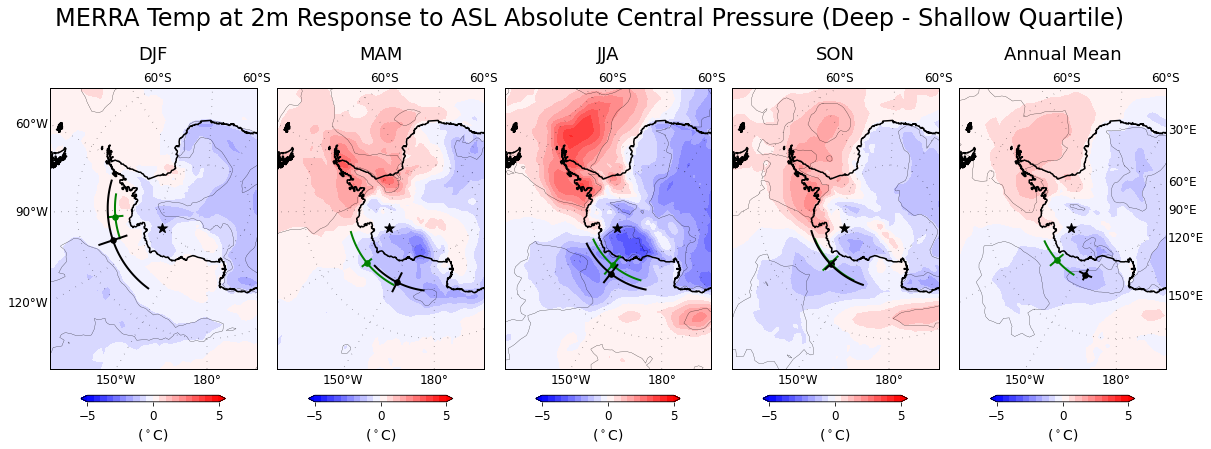

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('MERRA Temp at 2m Response to ASL Absolute Central Pressure (Deep - Shallow Quartile)', fontsize=24, y=1.05)

# setup Lambert Conformal basemap.
diff_djf = djf_t2m_w_deepmost_abs_cp_detrend_merra.mean(axis=0)-djf_t2m_w_shallowmost_abs_cp_detrend_merra.mean(axis=0)
diff_mam = mam_t2m_w_deepmost_abs_cp_detrend_merra.mean(axis=0)-mam_t2m_w_shallowmost_abs_cp_detrend_merra.mean(axis=0)
diff_jja = jja_t2m_w_deepmost_abs_cp_detrend_merra.mean(axis=0)-jja_t2m_w_shallowmost_abs_cp_detrend_merra.mean(axis=0)
diff_son = son_t2m_w_deepmost_abs_cp_detrend_merra.mean(axis=0)-son_t2m_w_shallowmost_abs_cp_detrend_merra.mean(axis=0)
diff_ann = ann_mean_t2m_w_deepmost_abs_cp_detrend_merra.mean(axis=0)-ann_mean_t2m_w_shallowmost_abs_cp_detrend_merra.mean(axis=0)
diff_djf_sh, lons = add_cyclic_point(diff_djf.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_mam_sh, lons = add_cyclic_point(diff_mam.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_jja_sh, lons = add_cyclic_point(diff_jja.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_son_sh, lons = add_cyclic_point(diff_son.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_ann_sh, lons = add_cyclic_point(diff_ann.values, MERRA_DATA.coords['lon'].values, axis=-1)
diff_djf_con, lons = add_cyclic_point(djf_t2m_change_due_to_abs_cp_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)
diff_mam_con, lons = add_cyclic_point(mam_t2m_change_due_to_abs_cp_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)
diff_jja_con, lons = add_cyclic_point(jja_t2m_change_due_to_abs_cp_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)
diff_son_con, lons = add_cyclic_point(son_t2m_change_due_to_abs_cp_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)
diff_ann_con, lons = add_cyclic_point(ann_mean_t2m_change_due_to_abs_cp_ttest_stats_merra, MERRA_DATA.coords['lon'].values, axis=-1)

lon, lat = np.meshgrid(lons,MERRA_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-5,5.5,.5)
levels_contour = [-2.101,2.101] #good for seasons and annual mean

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(djf_t2m_w_deepmost_abs_cp_detrend_merra.mean(axis=0)-djf_t2m_w_shallowmost_abs_cp_detrend_merra.mean(axis=0)).where((djf_t2m_change_due_to_abs_cp_ttest_stats_merra >= levels_contour[1]) | (djf_t2m_change_due_to_abs_cp_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_djf_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_djf_con,levels_contour,linewidths=0.25,colors='k')

#add Abs. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.mean(),
            djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.mean(),
            djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.mean()
                       ,djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.mean()+djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.std()
                       ,djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.mean()-djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.mean()+djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.std()
                       ,djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.mean()-djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.mean()
                       ,djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.mean()
                       ,djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.mean()+djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.std()
                       ,djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.mean()-djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.mean()+djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.std()
                       ,djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.mean()-djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.mean()
                       ,djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.vals.mean(),djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(mam_t2m_w_deepmost_abs_cp_detrend_merra.mean(axis=0)-mam_t2m_w_shallowmost_abs_cp_detrend_merra.mean(axis=0)).where((mam_t2m_change_due_to_abs_cp_ttest_stats_merra >= levels_contour[1]) | (mam_t2m_change_due_to_abs_cp_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_mam_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_mam_con,levels_contour,linewidths=0.25,colors='k')

#add Abs. CP mean location for upper and lower indice
#upper
xpt,ypt = m(mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.mean(),
            mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.mean(),
            mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.mean()
                       ,mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.mean()+mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.std()
                       ,mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.mean()-mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.mean()+mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.std()
                       ,mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.mean()-mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.mean()
                       ,mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.mean()
                       ,mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.mean()+mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.std()
                       ,mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.mean()-mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.mean()+mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.std()
                       ,mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.mean()-mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.mean()
                       ,mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.vals.mean(),mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.vals.mean())


#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(jja_t2m_w_deepmost_abs_cp_detrend_merra.mean(axis=0)-jja_t2m_w_shallowmost_abs_cp_detrend_merra.mean(axis=0)).where((jja_t2m_change_due_to_abs_cp_ttest_stats_merra >= levels_contour[1]) | (jja_t2m_change_due_to_abs_cp_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_jja_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_jja_con,levels_contour,linewidths=0.25,colors='k')

#add Abs. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.mean(),
            jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.mean(),
            jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.mean()
                       ,jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.mean()+jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.std()
                       ,jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.mean()-jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.mean()+jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.std()
                       ,jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.mean()-jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.mean()
                       ,jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.mean()
                       ,jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.mean()+jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.std()
                       ,jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.mean()-jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.mean()+jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.std()
                       ,jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.mean()-jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.mean()
                       ,jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.vals.mean(),jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.vals.mean())


#SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(son_t2m_w_deepmost_abs_cp_detrend_merra.mean(axis=0)-son_t2m_w_shallowmost_abs_cp_detrend_merra.mean(axis=0)).where((son_t2m_change_due_to_abs_cp_ttest_stats_merra >= levels_contour[1]) | (son_t2m_change_due_to_abs_cp_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_son_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_son_con,levels_contour,linewidths=0.25,colors='k')

#add Abs. CP mean location for upper and lower indice
#upper
xpt,ypt = m(son_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.mean(),
            son_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.mean(),
            son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(son_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.mean()
                       ,son_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.mean()+son_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.std()
                       ,son_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.mean()-son_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(son_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.mean()+son_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.std()
                       ,son_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.mean()-son_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(son_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.mean()
                       ,son_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.mean()
                       ,son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.mean()+son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.std()
                       ,son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.mean()-son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.mean()+son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.std()
                       ,son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.mean()-son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.mean()
                       ,son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.vals.mean(),son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.vals.mean())


#Annual Mean
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(ann_mean_t2m_w_deepmost_abs_cp_detrend_merra.mean(axis=0)-ann_mean_t2m_w_shallowmost_abs_cp_detrend_merra.mean(axis=0)).where((ann_mean_t2m_change_due_to_abs_cp_ttest_stats_merra >= levels_contour[1]) | (ann_mean_t2m_change_due_to_abs_cp_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_ann_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,diff_ann_con,levels_contour,linewidths=0.25,colors='k')

#add Abs. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.mean(),
            ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.mean(),
            ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.mean()
                       ,ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.mean()+ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.std()
                       ,ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.mean()-ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.mean()+ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.std()
                       ,ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.mean()-ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.mean()
                       ,ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.mean()
                       ,ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.mean()+ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.std()
                       ,ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.mean()-ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.mean()+ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.std()
                       ,ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.mean()-ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.mean()
                       ,ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
#plt.annotate('Jul-24-2012', xy=(0, 1), xycoords='axes fraction')
print(ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_merra.vals.mean(),ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_merra.vals.mean())


# plt.savefig(FIG_PATH+'/Figure_MERRA_t2m_Field_vs_ASL_Abs_CP_Values_Quartiles_01May2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

# DO REGRESSION ANALYSIS
## For Reviews

### We want a seasonal and annual time series of SAM, PSA1, PSA2, ASL Lon, ASL Rel CP, and ASL Abs CP

In [52]:
#Find SAM values for each of the 8 time periods and put in pd.DataFrame
#Then, select the upper and lower quartile values

###SAM
# SAM_djf_mean_merra
# SAM_jja_mean_merra
# SAM_ann_mean_merra 

###PSA1
# PSA1_djf_mean_merra
# PSA1_jja_mean_merra
# PSA1_ann_mean_merra

###PSA2
# PSA2_djf_mean_merra
# PSA2_jja_mean_merra
# PSA2_ann_mean_merra

###ASL lons
lons_djf_mean_merra = Rel_CP_djf_mean_indices_raw_merra.drop(columns=['vals','lats','sectormean'])
lons_jja_mean_merra = Rel_CP_jja_mean_indices_raw_merra.drop(columns=['vals','lats','sectormean'])
lons_ann_mean_merra = Rel_CP_ann_mean_indices_raw_merra.drop(columns=['vals','lats','sectormean'])

###ASL Rel CP
rel_cp_djf_mean_merra = Rel_CP_djf_mean_indices_raw_merra.drop(columns=['lons','lats','sectormean'])
rel_cp_jja_mean_merra = Rel_CP_jja_mean_indices_raw_merra.drop(columns=['lons','lats','sectormean'])
rel_cp_ann_mean_merra = Rel_CP_ann_mean_indices_raw_merra.drop(columns=['lons','lats','sectormean'])

###ASL Abs CP
abs_cp_djf_mean_merra = Abs_CP_djf_mean_indices_raw_merra.drop(columns=['lons','lats','sectormean','vals'])
abs_cp_jja_mean_merra = Abs_CP_jja_mean_indices_raw_merra.drop(columns=['lons','lats','sectormean','vals'])
abs_cp_ann_mean_merra = Abs_CP_ann_mean_indices_raw_merra.drop(columns=['lons','lats','sectormean','vals'])

### We want a map of T2M for each of the seasons and annual mean

In [53]:
# djf_t2m_shem_seas_mean_detrend_merra
# jja_t2m_shem_seas_mean_detrend_merra
ann_mean_t2m_shem_seas_mean_detrend_merra = t2m_shem_ann_mean_detrend_merra

### Regression Calculation

#### Regress SAM onto T2M

In [54]:
#Note, for the time series input, must select the column name and .values

##### SAM
###djf
slope_sam_djf, intercept_sam_djf, r_value_sam_djf, p_value_sam_djf, std_err_sam_djf = xr.apply_ufunc(stats.linregress,
                                                                                 SAM_djf_mean_merra['SAM'].values,
                                                                                 djf_t2m_shem_seas_mean_detrend_merra,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_sam_djf = r_value_sam_djf**2

###jja
slope_sam_jja, intercept_sam_jja, r_value_sam_jja, p_value_sam_jja, std_err_sam_jja = xr.apply_ufunc(stats.linregress,
                                                                                 SAM_jja_mean_merra['SAM'].values,
                                                                                 jja_t2m_shem_seas_mean_detrend_merra,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_sam_jja = r_value_sam_jja**2

###ann_mean
slope_sam_ann_mean, intercept_sam_ann_mean, r_value_sam_ann_mean, p_value_sam_ann_mean, std_err_sam_ann_mean = xr.apply_ufunc(stats.linregress,
                                                                                 SAM_ann_mean_merra['SAM'].values,
                                                                                 ann_mean_t2m_shem_seas_mean_detrend_merra,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_sam_ann_mean = r_value_sam_ann_mean**2

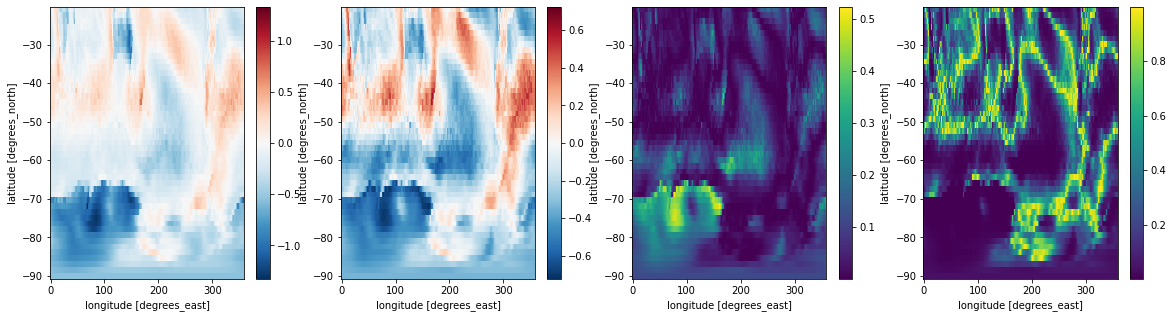

In [55]:
# use xarray to make a tester plot of the r values and p values to see the range to be sure looks about right 
fig = plt.figure(figsize=(20,5))

rsquared = r_value_sam_djf*r_value_sam_djf #multiplying rval * rval to get rsquared

ax = plt.subplot(1,4,1)
slope_sam_djf.plot()

ax = plt.subplot(1,4,2)
r_value_sam_djf.plot()

ax = plt.subplot(1,4,3)
rsquared.plot()

ax = plt.subplot(1,4,4)
p_value_sam_djf.plot()

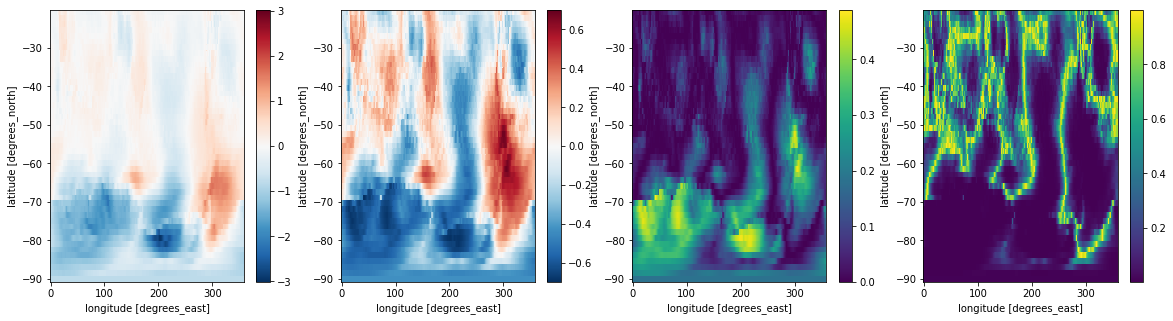

In [56]:
# use xarray to make a tester plot of the r values and p values to see the range to be sure looks about right 
fig = plt.figure(figsize=(20,5))

rsquared = r_value_sam_ann_mean*r_value_sam_ann_mean #multiplying rval * rval to get rsquared

ax = plt.subplot(1,4,1)
slope_sam_ann_mean.plot()

ax = plt.subplot(1,4,2)
r_value_sam_ann_mean.plot()

ax = plt.subplot(1,4,3)
rsquared.plot()

ax = plt.subplot(1,4,4)
p_value_sam_ann_mean.plot()

#### Now make a matrix of numbers and NaNs where the rsquared and pvals meet certain criteria

In [57]:
# threshold_rsquared = 0.5
# threshold_pval = 0.01

# stipple = rsquared.where(rsquared > threshold_rsquared) #note that the xarray where command keeps all values meeting criteria, others nan/missing
# stipple = stipple.where(p_value_annual < threshold_pval) #now find everywhere pvals meet threshold (AKA significant)
# stipple = stipple.where(xr.ufuncs.logical_not(stipple > 0) , 1) #OK, now we should have rsquared vals where significant, missing/zero where not, so let's replace rsquared with 1 so we have missing/zero and 1 values

# stipple

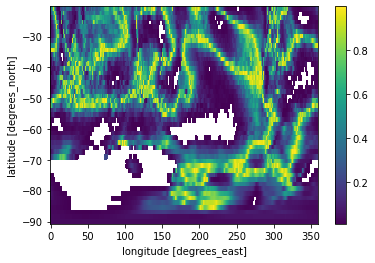

In [58]:
p_value_sam_djf.where(p_value_sam_djf >= 0.01).plot()

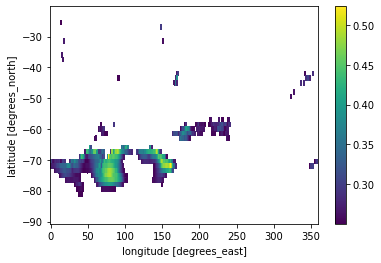

In [59]:
r2_value_sam_djf.where(r2_value_sam_djf >= 0.25).plot()

In [60]:
######  Ideas For Statistical Significance of the Regression Slope   ######

pval_threshold = 0.01
r2_threshold   = 0.15

#Contour where the p-value is below threshold
modify1_p_value_sam_djf = p_value_sam_djf.where(p_value_sam_djf <= pval_threshold, 0)  #select values below threshold, others equal 0
modify2_p_value_sam_djf = modify1_p_value_sam_djf.where(modify1_p_value_sam_djf == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

modify1_p_value_sam_jja = p_value_sam_jja.where(p_value_sam_jja <= pval_threshold, 0)  #select values below threshold, others equal 0
modify2_p_value_sam_jja = modify1_p_value_sam_jja.where(modify1_p_value_sam_jja == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

modify1_p_value_sam_ann_mean = p_value_sam_ann_mean.where(p_value_sam_ann_mean <= pval_threshold, 0)  #select values below threshold, others equal 0
modify2_p_value_sam_ann_mean = modify1_p_value_sam_ann_mean.where(modify1_p_value_sam_ann_mean == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

#Contour where the r-squared is above threshold
modify1_r2_value_sam_djf = r2_value_sam_djf.where(r2_value_sam_djf >= r2_threshold, 0)  #select values below threshold, others equal 0
modify2_r2_value_sam_djf = modify1_r2_value_sam_djf.where(modify1_r2_value_sam_djf == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

modify1_r2_value_sam_jja = r2_value_sam_jja.where(r2_value_sam_jja >= r2_threshold, 0)  #select values below threshold, others equal 0
modify2_r2_value_sam_jja = modify1_r2_value_sam_jja.where(modify1_r2_value_sam_jja == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

modify1_r2_value_sam_ann_mean = r2_value_sam_ann_mean.where(r2_value_sam_ann_mean >= r2_threshold, 0)  #select values below threshold, others equal 0
modify2_r2_value_sam_ann_mean = modify1_r2_value_sam_ann_mean.where(modify1_r2_value_sam_ann_mean == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

#Combine the two criteria
threshold_r2_p_value_sam_djf = modify2_r2_value_sam_djf.where(modify2_p_value_sam_djf == 1, 0)
threshold_r2_p_value_sam_jja = modify2_r2_value_sam_jja.where(modify2_p_value_sam_jja == 1, 0)
threshold_r2_p_value_sam_ann_mean = modify2_r2_value_sam_ann_mean.where(modify2_p_value_sam_ann_mean == 1, 0)

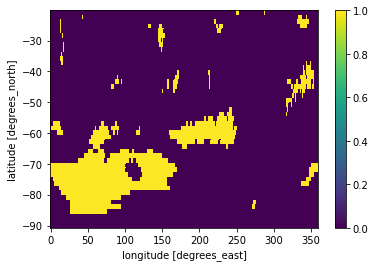

In [61]:
modify2_p_value_sam_djf.plot()

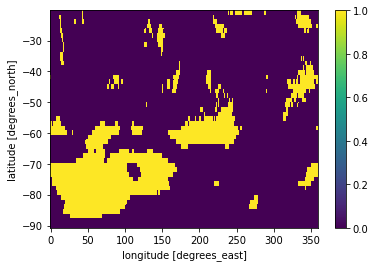

In [62]:
modify2_r2_value_sam_djf.plot()

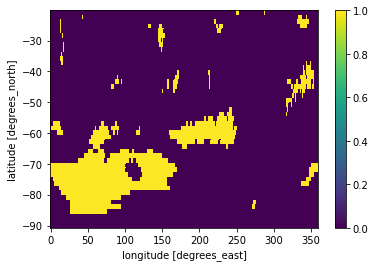

In [63]:
threshold_r2_p_value_sam_djf.plot()

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-6.260950395785244 -5.040241222356776


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:129: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-8.581004670485925 -7.325814611210513


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:217: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-6.069207265795103 -5.398468043874834


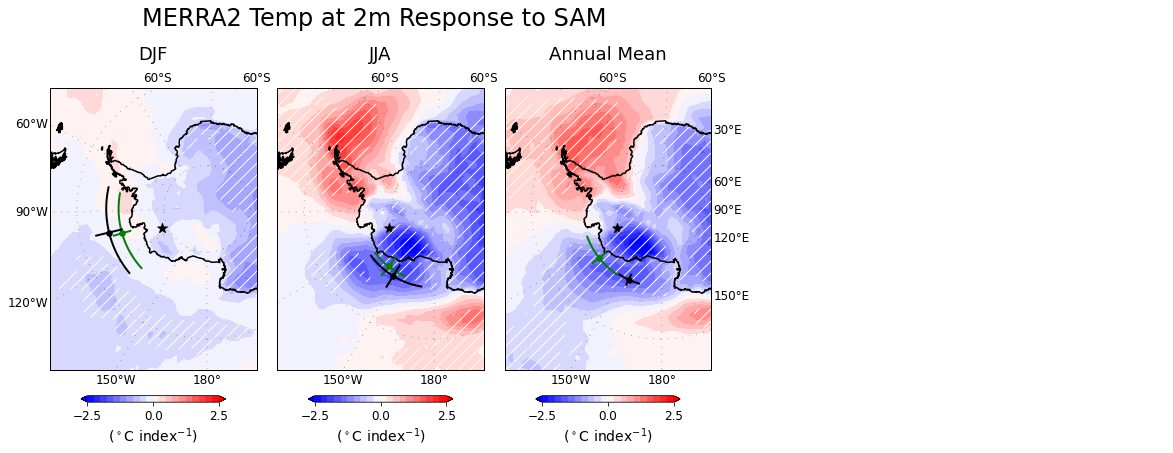

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('MERRA2 Temp at 2m Response to SAM', fontsize=24, y=1.05, x = 0.35)

# setup Lambert Conformal basemap.

# slope shades -- add cyclic
slope_djf_sh, lons = add_cyclic_point(slope_sam_djf.values, MERRA_DATA.coords['lon'].values, axis=-1)
slope_jja_sh, lons = add_cyclic_point(slope_sam_jja.values, MERRA_DATA.coords['lon'].values, axis=-1)
slope_ann_mean_sh, lons = add_cyclic_point(slope_sam_ann_mean.values, MERRA_DATA.coords['lon'].values, axis=-1)
# p-value contour -- add cyclic
p_value_djf_con, lons = add_cyclic_point(modify2_p_value_sam_djf.values, MERRA_DATA.coords['lon'].values, axis=-1)
p_value_jja_con, lons = add_cyclic_point(modify2_p_value_sam_jja.values, MERRA_DATA.coords['lon'].values, axis=-1)
p_value_ann_mean_con, lons = add_cyclic_point(modify2_p_value_sam_ann_mean.values, MERRA_DATA.coords['lon'].values, axis=-1)
# r2-value contour -- add cyclic
r2_value_djf_con, lons = add_cyclic_point(modify2_r2_value_sam_djf.values, MERRA_DATA.coords['lon'].values, axis=-1)
r2_value_jja_con, lons = add_cyclic_point(modify2_r2_value_sam_jja.values, MERRA_DATA.coords['lon'].values, axis=-1)
r2_value_ann_mean_con, lons = add_cyclic_point(modify2_r2_value_sam_ann_mean.values, MERRA_DATA.coords['lon'].values, axis=-1)
# r2 and p-value threshold contour -- add cyclic
threshold_r2_p_value_sam_djf_con, lons = add_cyclic_point(threshold_r2_p_value_sam_djf.values, MERRA_DATA.coords['lon'].values, axis=-1)
threshold_r2_p_value_sam_jja_con, lons = add_cyclic_point(threshold_r2_p_value_sam_jja.values, MERRA_DATA.coords['lon'].values, axis=-1)
threshold_r2_p_value_sam_ann_mean_con, lons = add_cyclic_point(threshold_r2_p_value_sam_ann_mean.values, MERRA_DATA.coords['lon'].values, axis=-1)




lon, lat = np.meshgrid(lons,MERRA_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-2.5,2.75,0.25)
levels_contour = [1]

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,(slope_djf_sh), levels, cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'($^\circ$C index$^{-1}$)',size=14)
cbar.set_ticks([-2.5, 0, 2.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-2.5,2.5])
#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
# CS2 = m.contour(x,y,p_value_djf_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,r2_value_djf_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,threshold_r2_p_value_sam_djf_con, levels_contour, linewidths=0.35,colors='k')
mpl.rcParams['hatch.color'] = 'lightyellow' #use this line to change stipple color
CS2 = m.contourf(x, y, threshold_r2_p_value_sam_djf_con, levels = [0,0.5,1], hatches=['','//'], alpha=0)

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

# #add point for central Psuedo cores
# xpt,ypt = m(247.5, -78.63)
# plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.vals.mean(),djf_Rel_CP_indices_w_lower_SAM_detrend_merra.vals.mean())







#JJA
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,(slope_jja_sh), levels, cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'($^\circ$C index$^{-1}$)',size=14)
cbar.set_ticks([-2.5, 0, 2.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-2.5,2.5])
#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
# CS2 = m.contour(x,y,p_value_jja_con,levels_contour,linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,r2_value_jja_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,threshold_r2_p_value_sam_jja_con, levels_contour, linewidths=0.35,colors='k')
mpl.rcParams['hatch.color'] = 'lightyellow' #use this line to change stipple color
CS2 = m.contourf(x, y, threshold_r2_p_value_sam_jja_con, levels = [0,0.5,1], hatches=['','//'], alpha=0)

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

# #add point for central Psuedo cores
# xpt,ypt = m(247.5, -78.63)
# plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.vals.mean(),jja_Rel_CP_indices_w_lower_SAM_detrend_merra.vals.mean())





#Annual Mean
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,(slope_ann_mean_sh), levels, cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'($^\circ$C index$^{-1}$)',size=14)
cbar.set_ticks([-2.5, 0, 2.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-2.5,2.5])
#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
# CS2 = m.contour(x,y,p_value_ann_mean_con,levels_contour,linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,r2_value_ann_mean_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,threshold_r2_p_value_sam_ann_mean_con, levels_contour, linewidths=0.35,colors='k')
mpl.rcParams['hatch.color'] = 'lightyellow' #use this line to change stipple color
CS2 = m.contourf(x, y, threshold_r2_p_value_sam_ann_mean_con, levels = [0,0.5,1], hatches=['','//'], alpha=0)

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

# #add point for central Psuedo cores
# xpt,ypt = m(247.5, -78.63)
# plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.vals.mean(),ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.vals.mean())



ax[-2].axis('off')
ax[-1].axis('off')



plt.savefig(FIG_PATH+'/New_Regression_Figure_MERRA_TAGGED_t2m_Field_vs_SAM_Quartiles_20210324.pdf',bbox_inches='tight', pad_inches=0.05)




plt.show()

In [65]:
#Indices for WDC location are lat = -9 and lon = -75
# Initialise data to lists.
data = [{'slope': np.round(slope_sam_djf.isel(lat=-9,lon=-75).values,3), 'r-sq': np.round(r2_value_sam_djf.isel(lat=-9,lon=-75).values,3), 'p-val':np.round(p_value_sam_djf.isel(lat=-9,lon=-75).values,3)},
        {'slope': np.round(slope_sam_jja.isel(lat=-9,lon=-75).values,3), 'r-sq': np.round(r2_value_sam_jja.isel(lat=-9,lon=-75).values,3), 'p-val':np.round(p_value_sam_jja.isel(lat=-9,lon=-75).values,3)},
        {'slope': np.round(slope_sam_ann_mean.isel(lat=-9,lon=-75).values,3), 'r-sq': np.round(r2_value_sam_ann_mean.isel(lat=-9,lon=-75).values,3), 'p-val':np.round(p_value_sam_ann_mean.isel(lat=-9,lon=-75).values,3)}]
  
# Creates DataFrame.
df = pd.DataFrame(data, index =['DJF', 'JJA', 'ANN'])
  
# Print the data
df

,slope,r-sq,p-val
DJF,-0.224,0.016,0.460
JJA,-1.042,0.121,0.033
ANN,-1.031,0.156,0.014


### Print Slope as 1D array

In [66]:
# np.savetxt(FIG_PATH+'/Slope_MERRA2_T2M_DJF_SAM.txt',slope_sam_djf.where(land_tmon_ctrl[22,4:20,72:109] > 0.1).dropna(dim='lat').dropna(dim='lon').values.flatten(), fmt='%.5f', newline=os.linesep)

In [67]:
# np.savetxt(FIG_PATH+'/Slope_MERRA2_T2M_JJA_SAM.txt',slope_sam_jja.where(land_tmon_ctrl[22,4:20,72:109] > 0.1).dropna(dim='lat').dropna(dim='lon').values.flatten(), fmt='%.5f', newline=os.linesep)

In [68]:
np.savetxt(FIG_PATH+'/Slope_MERRA2_T2M_DJF_SAM.txt',slope_sam_djf[4:20,72:144].dropna(dim='lat').dropna(dim='lon').values.flatten(), fmt='%.5f', newline=os.linesep)

In [69]:
np.savetxt(FIG_PATH+'/Slope_MERRA2_T2M_JJA_SAM.txt',slope_sam_jja[4:20,72:144].dropna(dim='lat').dropna(dim='lon').values.flatten(), fmt='%.5f', newline=os.linesep)

#### Regress PSA1 onto T2M

In [70]:
#Note, for the time series input, must select the column name and .values

##### PSA1
###djf
slope_psa1_djf, intercept_psa1_djf, r_value_psa1_djf, p_value_psa1_djf, std_err_psa1_djf = xr.apply_ufunc(stats.linregress,
                                                                                 PSA1_djf_mean_merra['PSA1'].values,
                                                                                 djf_t2m_shem_seas_mean_detrend_merra,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_psa1_djf = r_value_psa1_djf**2

###jja
slope_psa1_jja, intercept_psa1_jja, r_value_psa1_jja, p_value_psa1_jja, std_err_psa1_jja = xr.apply_ufunc(stats.linregress,
                                                                                 PSA1_jja_mean_merra['PSA1'].values,
                                                                                 jja_t2m_shem_seas_mean_detrend_merra,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_psa1_jja = r_value_psa1_jja**2

###ann_mean
slope_psa1_ann_mean, intercept_psa1_ann_mean, r_value_psa1_ann_mean, p_value_psa1_ann_mean, std_err_psa1_ann_mean = xr.apply_ufunc(stats.linregress,
                                                                                 PSA1_ann_mean_merra['PSA1'].values,
                                                                                 ann_mean_t2m_shem_seas_mean_detrend_merra,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_psa1_ann_mean = r_value_psa1_ann_mean**2

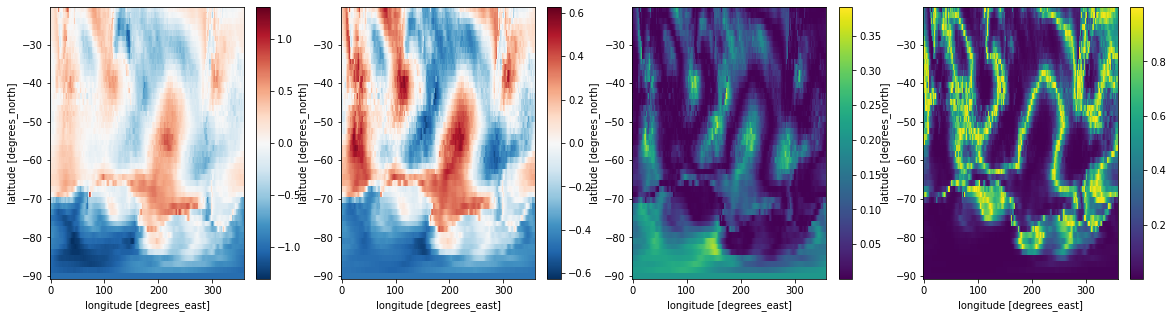

In [71]:
# use xarray to make a tester plot of the r values and p values to see the range to be sure looks about right 
fig = plt.figure(figsize=(20,5))

rsquared = r_value_psa1_djf*r_value_psa1_djf #multiplying rval * rval to get rsquared

ax = plt.subplot(1,4,1)
slope_psa1_djf.plot()

ax = plt.subplot(1,4,2)
r_value_psa1_djf.plot()

ax = plt.subplot(1,4,3)
rsquared.plot()

ax = plt.subplot(1,4,4)
p_value_psa1_djf.plot()

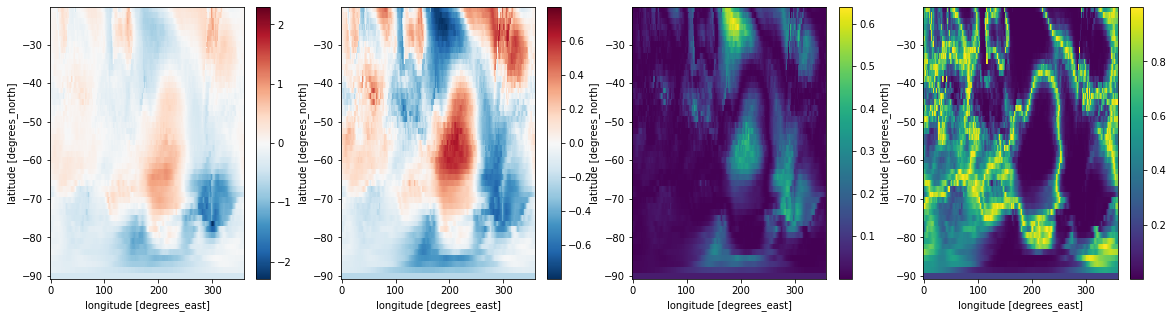

In [72]:
# use xarray to make a tester plot of the r values and p values to see the range to be sure looks about right 
fig = plt.figure(figsize=(20,5))

rsquared = r_value_psa1_ann_mean*r_value_psa1_ann_mean #multiplying rval * rval to get rsquared

ax = plt.subplot(1,4,1)
slope_psa1_ann_mean.plot()

ax = plt.subplot(1,4,2)
r_value_psa1_ann_mean.plot()

ax = plt.subplot(1,4,3)
rsquared.plot()

ax = plt.subplot(1,4,4)
p_value_psa1_ann_mean.plot()

#### Now make a matrix of numbers and NaNs where the rsquared and pvals meet certain criteria

In [73]:
# threshold_rsquared = 0.5
# threshold_pval = 0.01

# stipple = rsquared.where(rsquared > threshold_rsquared) #note that the xarray where command keeps all values meeting criteria, others nan/missing
# stipple = stipple.where(p_value_annual < threshold_pval) #now find everywhere pvals meet threshold (AKA significant)
# stipple = stipple.where(xr.ufuncs.logical_not(stipple > 0) , 1) #OK, now we should have rsquared vals where significant, missing/zero where not, so let's replace rsquared with 1 so we have missing/zero and 1 values

# stipple

In [74]:
######  Ideas For Statistical Significance of the Regression Slope   ######

pval_threshold = 0.01
r2_threshold   = 0.15

#Contour where the p-value is below threshold
modify1_p_value_psa1_djf = p_value_psa1_djf.where(p_value_psa1_djf <= pval_threshold, 0)  #select values below threshold, others equal 0
modify2_p_value_psa1_djf = modify1_p_value_psa1_djf.where(modify1_p_value_psa1_djf == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

modify1_p_value_psa1_jja = p_value_psa1_jja.where(p_value_psa1_jja <= pval_threshold, 0)  #select values below threshold, others equal 0
modify2_p_value_psa1_jja = modify1_p_value_psa1_jja.where(modify1_p_value_psa1_jja == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

modify1_p_value_psa1_ann_mean = p_value_psa1_ann_mean.where(p_value_psa1_ann_mean <= pval_threshold, 0)  #select values below threshold, others equal 0
modify2_p_value_psa1_ann_mean = modify1_p_value_psa1_ann_mean.where(modify1_p_value_psa1_ann_mean == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

#Contour where the r-squared is above threshold
modify1_r2_value_psa1_djf = r2_value_psa1_djf.where(r2_value_psa1_djf >= r2_threshold, 0)  #select values below threshold, others equal 0
modify2_r2_value_psa1_djf = modify1_r2_value_psa1_djf.where(modify1_r2_value_psa1_djf == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

modify1_r2_value_psa1_jja = r2_value_psa1_jja.where(r2_value_psa1_jja >= r2_threshold, 0)  #select values below threshold, others equal 0
modify2_r2_value_psa1_jja = modify1_r2_value_psa1_jja.where(modify1_r2_value_psa1_jja == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

modify1_r2_value_psa1_ann_mean = r2_value_psa1_ann_mean.where(r2_value_psa1_ann_mean >= r2_threshold, 0)  #select values below threshold, others equal 0
modify2_r2_value_psa1_ann_mean = modify1_r2_value_psa1_ann_mean.where(modify1_r2_value_psa1_ann_mean == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

#Combine the two criteria
threshold_r2_p_value_psa1_djf = modify2_r2_value_psa1_djf.where(modify2_p_value_psa1_djf == 1, 0)
threshold_r2_p_value_psa1_jja = modify2_r2_value_psa1_jja.where(modify2_p_value_psa1_jja == 1, 0)
threshold_r2_p_value_psa1_ann_mean = modify2_r2_value_psa1_ann_mean.where(modify2_p_value_psa1_ann_mean == 1, 0)

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-6.3973048946120095 -5.560755895294518


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:129: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-8.955573987724687 -7.127735119457259


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:217: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-5.877155766029318 -5.789190913936056


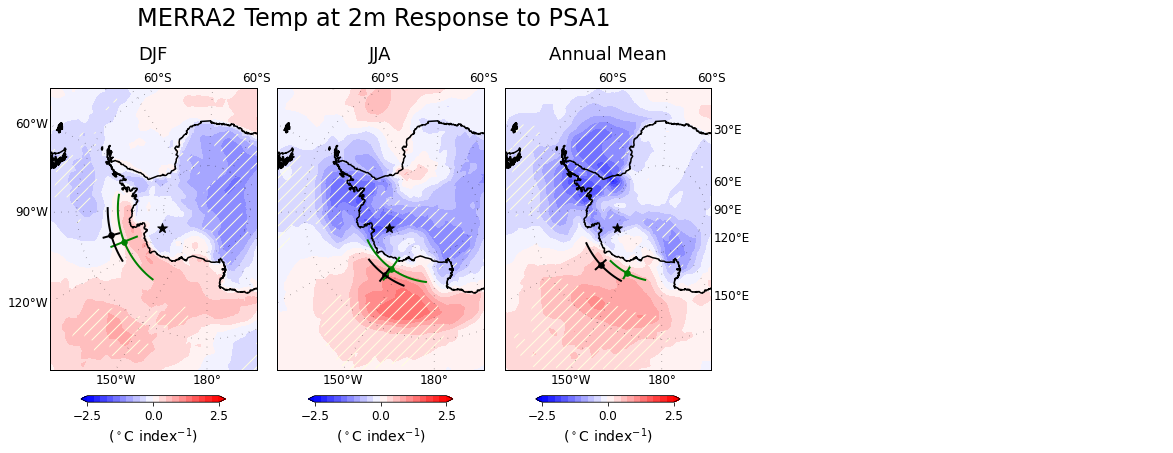

In [75]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('MERRA2 Temp at 2m Response to PSA1', fontsize=24, y=1.05, x = 0.35)

# setup Lambert Conformal basemap.

# slope shades -- add cyclic
slope_djf_sh, lons = add_cyclic_point(slope_psa1_djf.values, MERRA_DATA.coords['lon'].values, axis=-1)
slope_jja_sh, lons = add_cyclic_point(slope_psa1_jja.values, MERRA_DATA.coords['lon'].values, axis=-1)
slope_ann_mean_sh, lons = add_cyclic_point(slope_psa1_ann_mean.values, MERRA_DATA.coords['lon'].values, axis=-1)
# p-value contour -- add cyclic
p_value_djf_con, lons = add_cyclic_point(modify2_p_value_psa1_djf.values, MERRA_DATA.coords['lon'].values, axis=-1)
p_value_jja_con, lons = add_cyclic_point(modify2_p_value_psa1_jja.values, MERRA_DATA.coords['lon'].values, axis=-1)
p_value_ann_mean_con, lons = add_cyclic_point(modify2_p_value_psa1_ann_mean.values, MERRA_DATA.coords['lon'].values, axis=-1)
# r2-value contour -- add cyclic
r2_value_djf_con, lons = add_cyclic_point(modify2_r2_value_psa1_djf.values, MERRA_DATA.coords['lon'].values, axis=-1)
r2_value_jja_con, lons = add_cyclic_point(modify2_r2_value_psa1_jja.values, MERRA_DATA.coords['lon'].values, axis=-1)
r2_value_ann_mean_con, lons = add_cyclic_point(modify2_r2_value_psa1_ann_mean.values, MERRA_DATA.coords['lon'].values, axis=-1)
# r2 and p-value threshold contour -- add cyclic
threshold_r2_p_value_psa1_djf_con, lons = add_cyclic_point(threshold_r2_p_value_psa1_djf.values, MERRA_DATA.coords['lon'].values, axis=-1)
threshold_r2_p_value_psa1_jja_con, lons = add_cyclic_point(threshold_r2_p_value_psa1_jja.values, MERRA_DATA.coords['lon'].values, axis=-1)
threshold_r2_p_value_psa1_ann_mean_con, lons = add_cyclic_point(threshold_r2_p_value_psa1_ann_mean.values, MERRA_DATA.coords['lon'].values, axis=-1)




lon, lat = np.meshgrid(lons,MERRA_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-2.5,2.75,0.25)
levels_contour = [1]

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,(slope_djf_sh), levels, cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'($^\circ$C index$^{-1}$)',size=14)
cbar.set_ticks([-2.5, 0, 2.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-2.5,2.5])
#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
# CS2 = m.contour(x,y,p_value_djf_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,r2_value_djf_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,threshold_r2_p_value_psa1_djf_con, levels_contour, linewidths=0.35,colors='k')
mpl.rcParams['hatch.color'] = 'lightyellow' #use this line to change stipple color
CS2 = m.contourf(x, y, threshold_r2_p_value_psa1_djf_con, levels = [0,0.5,1], hatches=['','//'], alpha=0)

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

# #add point for central Psuedo cores
# xpt,ypt = m(247.5, -78.63)
# plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.vals.mean(),djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.vals.mean())







#JJA
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,(slope_jja_sh), levels, cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'($^\circ$C index$^{-1}$)',size=14)
cbar.set_ticks([-2.5, 0, 2.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-2.5,2.5])
#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
# CS2 = m.contour(x,y,p_value_jja_con,levels_contour,linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,r2_value_jja_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,threshold_r2_p_value_psa1_jja_con, levels_contour, linewidths=0.35,colors='k')
mpl.rcParams['hatch.color'] = 'lightyellow' #use this line to change stipple color
CS2 = m.contourf(x, y, threshold_r2_p_value_psa1_jja_con, levels = [0,0.5,1], hatches=['','//'], alpha=0)

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

# #add point for central Psuedo cores
# xpt,ypt = m(247.5, -78.63)
# plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.vals.mean(),jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.vals.mean())





#Annual Mean
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,(slope_ann_mean_sh), levels, cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'($^\circ$C index$^{-1}$)',size=14)
cbar.set_ticks([-2.5, 0, 2.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-2.5,2.5])
#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
# CS2 = m.contour(x,y,p_value_ann_mean_con,levels_contour,linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,r2_value_ann_mean_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,threshold_r2_p_value_psa1_ann_mean_con, levels_contour, linewidths=0.35,colors='k')
mpl.rcParams['hatch.color'] = 'lightyellow' #use this line to change stipple color
CS2 = m.contourf(x, y, threshold_r2_p_value_psa1_ann_mean_con, levels = [0,0.5,1], hatches=['','//'], alpha=0)

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

# #add point for central Psuedo cores
# xpt,ypt = m(247.5, -78.63)
# plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.vals.mean(),ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.vals.mean())



ax[-2].axis('off')
ax[-1].axis('off')



plt.savefig(FIG_PATH+'/New_Regression_Figure_MERRA2_TAGGED_t2m_Field_vs_PSA1_Quartiles_20210324.pdf',bbox_inches='tight', pad_inches=0.05)




plt.show()

In [76]:
#Indices for WDC location are lat = -9 and lon = -75
# Initialise data to lists.
data = [{'slope': np.round(slope_psa1_djf.isel(lat=-9,lon=-75).values,3), 'r-sq': np.round(r2_value_psa1_djf.isel(lat=-9,lon=-75).values,3), 'p-val':np.round(p_value_psa1_djf.isel(lat=-9,lon=-75).values,3)},
        {'slope': np.round(slope_psa1_jja.isel(lat=-9,lon=-75).values,3), 'r-sq': np.round(r2_value_psa1_jja.isel(lat=-9,lon=-75).values,3), 'p-val':np.round(p_value_psa1_jja.isel(lat=-9,lon=-75).values,3)},
        {'slope': np.round(slope_psa1_ann_mean.isel(lat=-9,lon=-75).values,3), 'r-sq': np.round(r2_value_psa1_ann_mean.isel(lat=-9,lon=-75).values,3), 'p-val':np.round(p_value_psa1_ann_mean.isel(lat=-9,lon=-75).values,3)}]
  
# Creates DataFrame.
df = pd.DataFrame(data, index =['DJF', 'JJA', 'ANN'])
  
# Print the data
df

,slope,r-sq,p-val
DJF,-0.290,0.014,0.482
JJA,-1.386,0.229,0.002
ANN,-0.790,0.091,0.066


### Print Slope as 1D array

In [77]:
# np.savetxt(FIG_PATH+'/Slope_MERRA2_T2M_DJF_PSA1.txt',slope_psa1_djf.where(land_tmon_ctrl[22,4:20,72:109] > 0.1).dropna(dim='lat').dropna(dim='lon').values.flatten(), fmt='%.5f', newline=os.linesep)

In [78]:
# np.savetxt(FIG_PATH+'/Slope_MERRA2_T2M_JJA_PSA1.txt',slope_psa1_jja.where(land_tmon_ctrl[22,4:20,72:109] > 0.1).dropna(dim='lat').dropna(dim='lon').values.flatten(), fmt='%.5f', newline=os.linesep)

In [79]:
np.savetxt(FIG_PATH+'/Slope_MERRA2_T2M_DJF_PSA1.txt',slope_psa1_djf[4:20,72:144].dropna(dim='lat').dropna(dim='lon').values.flatten(), fmt='%.5f', newline=os.linesep)

In [80]:
np.savetxt(FIG_PATH+'/Slope_MERRA2_T2M_JJA_PSA1.txt',slope_psa1_jja[4:20,72:144].dropna(dim='lat').dropna(dim='lon').values.flatten(), fmt='%.5f', newline=os.linesep)

#### Regress PSA2 onto T2M

In [81]:
#Note, for the time series input, must select the column name and .values

##### PSA2
###djf
slope_psa2_djf, intercept_psa2_djf, r_value_psa2_djf, p_value_psa2_djf, std_err_psa2_djf = xr.apply_ufunc(stats.linregress,
                                                                                 PSA2_djf_mean_merra['PSA2'].values,
                                                                                 djf_t2m_shem_seas_mean_detrend_merra,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_psa2_djf = r_value_psa2_djf**2

###jja
slope_psa2_jja, intercept_psa2_jja, r_value_psa2_jja, p_value_psa2_jja, std_err_psa2_jja = xr.apply_ufunc(stats.linregress,
                                                                                 PSA2_jja_mean_merra['PSA2'].values,
                                                                                 jja_t2m_shem_seas_mean_detrend_merra,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_psa2_jja = r_value_psa2_jja**2

###ann_mean
slope_psa2_ann_mean, intercept_psa2_ann_mean, r_value_psa2_ann_mean, p_value_psa2_ann_mean, std_err_psa2_ann_mean = xr.apply_ufunc(stats.linregress,
                                                                                 PSA2_ann_mean_merra['PSA2'].values,
                                                                                 ann_mean_t2m_shem_seas_mean_detrend_merra,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_psa2_ann_mean = r_value_psa2_ann_mean**2

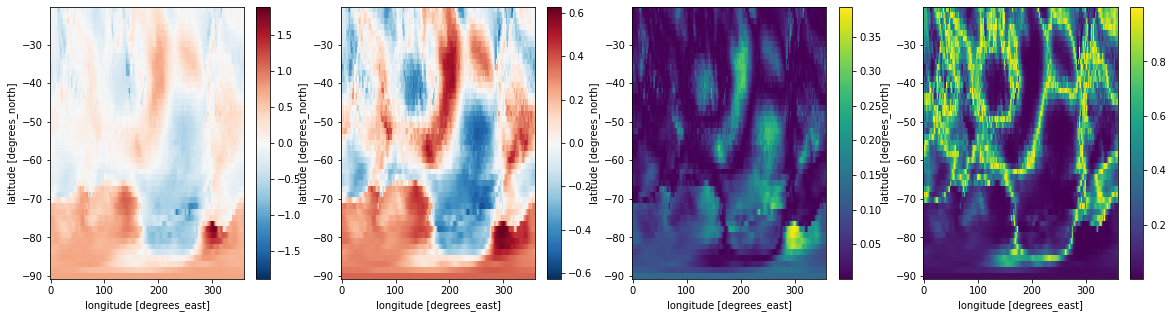

In [82]:
# use xarray to make a tester plot of the r values and p values to see the range to be sure looks about right 
fig = plt.figure(figsize=(20,5))

rsquared = r_value_psa2_djf*r_value_psa2_djf #multiplying rval * rval to get rsquared

ax = plt.subplot(1,4,1)
slope_psa2_djf.plot()

ax = plt.subplot(1,4,2)
r_value_psa2_djf.plot()

ax = plt.subplot(1,4,3)
rsquared.plot()

ax = plt.subplot(1,4,4)
p_value_psa2_djf.plot()

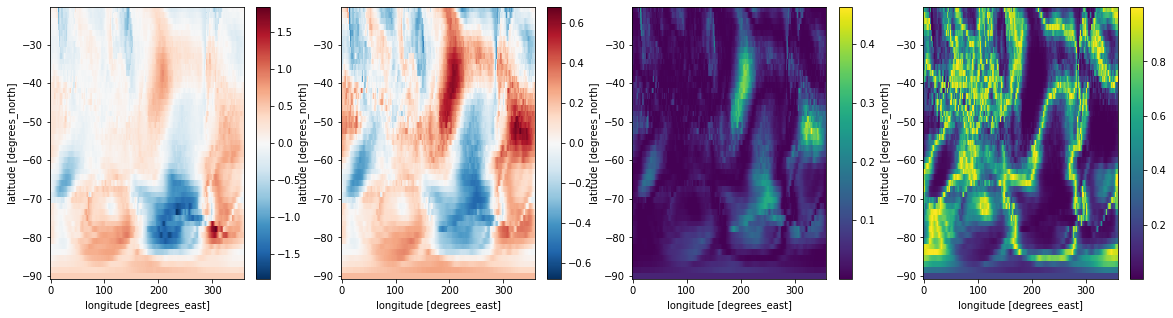

In [83]:
# use xarray to make a tester plot of the r values and p values to see the range to be sure looks about right 
fig = plt.figure(figsize=(20,5))

rsquared = r_value_psa2_ann_mean*r_value_psa2_ann_mean #multiplying rval * rval to get rsquared

ax = plt.subplot(1,4,1)
slope_psa2_ann_mean.plot()

ax = plt.subplot(1,4,2)
r_value_psa2_ann_mean.plot()

ax = plt.subplot(1,4,3)
rsquared.plot()

ax = plt.subplot(1,4,4)
p_value_psa2_ann_mean.plot()

#### Now make a matrix of numbers and NaNs where the rsquared and pvals meet certain criteria

In [84]:
# threshold_rsquared = 0.5
# threshold_pval = 0.01

# stipple = rsquared.where(rsquared > threshold_rsquared) #note that the xarray where command keeps all values meeting criteria, others nan/missing
# stipple = stipple.where(p_value_annual < threshold_pval) #now find everywhere pvals meet threshold (AKA significant)
# stipple = stipple.where(xr.ufuncs.logical_not(stipple > 0) , 1) #OK, now we should have rsquared vals where significant, missing/zero where not, so let's replace rsquared with 1 so we have missing/zero and 1 values

# stipple

In [85]:
######  Ideas For Statistical Significance of the Regression Slope   ######

pval_threshold = 0.01
r2_threshold   = 0.15

#Contour where the p-value is below threshold
modify1_p_value_psa2_djf = p_value_psa2_djf.where(p_value_psa2_djf <= pval_threshold, 0)  #select values below threshold, others equal 0
modify2_p_value_psa2_djf = modify1_p_value_psa2_djf.where(modify1_p_value_psa2_djf == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

modify1_p_value_psa2_jja = p_value_psa2_jja.where(p_value_psa2_jja <= pval_threshold, 0)  #select values below threshold, others equal 0
modify2_p_value_psa2_jja = modify1_p_value_psa2_jja.where(modify1_p_value_psa2_jja == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

modify1_p_value_psa2_ann_mean = p_value_psa2_ann_mean.where(p_value_psa2_ann_mean <= pval_threshold, 0)  #select values below threshold, others equal 0
modify2_p_value_psa2_ann_mean = modify1_p_value_psa2_ann_mean.where(modify1_p_value_psa2_ann_mean == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

#Contour where the r-squared is above threshold
modify1_r2_value_psa2_djf = r2_value_psa2_djf.where(r2_value_psa2_djf >= r2_threshold, 0)  #select values below threshold, others equal 0
modify2_r2_value_psa2_djf = modify1_r2_value_psa2_djf.where(modify1_r2_value_psa2_djf == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

modify1_r2_value_psa2_jja = r2_value_psa2_jja.where(r2_value_psa2_jja >= r2_threshold, 0)  #select values below threshold, others equal 0
modify2_r2_value_psa2_jja = modify1_r2_value_psa2_jja.where(modify1_r2_value_psa2_jja == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

modify1_r2_value_psa2_ann_mean = r2_value_psa2_ann_mean.where(r2_value_psa2_ann_mean >= r2_threshold, 0)  #select values below threshold, others equal 0
modify2_r2_value_psa2_ann_mean = modify1_r2_value_psa2_ann_mean.where(modify1_r2_value_psa2_ann_mean == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

#Combine the two criteria
threshold_r2_p_value_psa2_djf = modify2_r2_value_psa2_djf.where(modify2_p_value_psa2_djf == 1, 0)
threshold_r2_p_value_psa2_jja = modify2_r2_value_psa2_jja.where(modify2_p_value_psa2_jja == 1, 0)
threshold_r2_p_value_psa2_ann_mean = modify2_r2_value_psa2_ann_mean.where(modify2_p_value_psa2_ann_mean == 1, 0)

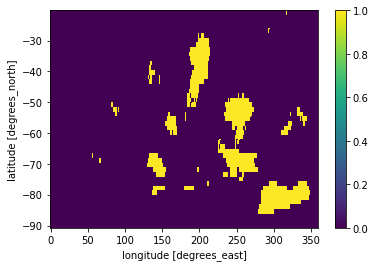

In [86]:
threshold_r2_p_value_psa2_djf.plot() #So, if stippling, we'd want to stipple where 1's are


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-6.805188966140829 -5.078415975272542


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:129: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-7.791644566281081 -8.706484988630962


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:217: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-5.434098196360674 -5.81004511551555


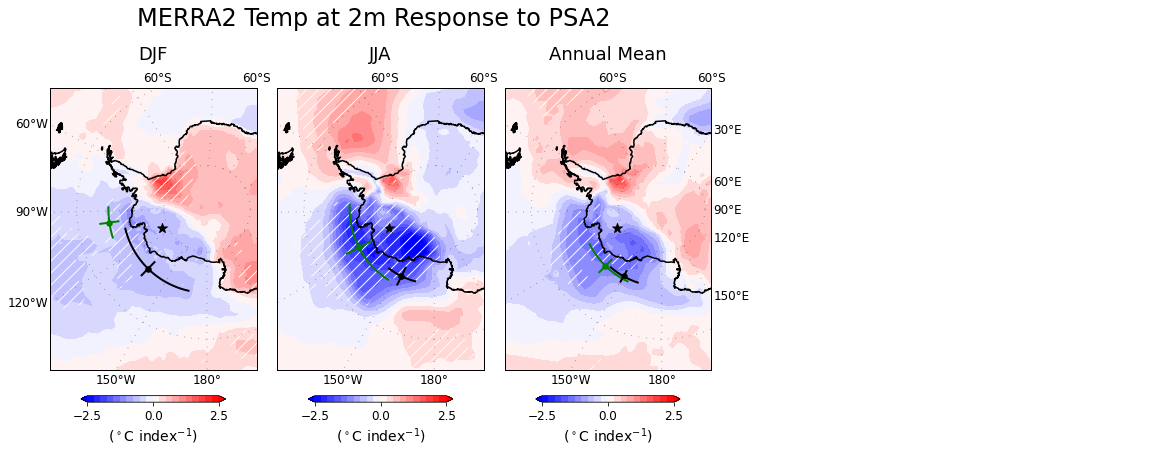

In [87]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('MERRA2 Temp at 2m Response to PSA2', fontsize=24, y=1.05, x = 0.35)

# setup Lambert Conformal basemap.

# slope shades -- add cyclic
slope_djf_sh, lons = add_cyclic_point(slope_psa2_djf.values, MERRA_DATA.coords['lon'].values, axis=-1)
slope_jja_sh, lons = add_cyclic_point(slope_psa2_jja.values, MERRA_DATA.coords['lon'].values, axis=-1)
slope_ann_mean_sh, lons = add_cyclic_point(slope_psa2_ann_mean.values, MERRA_DATA.coords['lon'].values, axis=-1)
# p-value contour -- add cyclic
p_value_djf_con, lons = add_cyclic_point(modify2_p_value_psa2_djf.values, MERRA_DATA.coords['lon'].values, axis=-1)
p_value_jja_con, lons = add_cyclic_point(modify2_p_value_psa2_jja.values, MERRA_DATA.coords['lon'].values, axis=-1)
p_value_ann_mean_con, lons = add_cyclic_point(modify2_p_value_psa2_ann_mean.values, MERRA_DATA.coords['lon'].values, axis=-1)
# r2-value contour -- add cyclic
r2_value_djf_con, lons = add_cyclic_point(modify2_r2_value_psa2_djf.values, MERRA_DATA.coords['lon'].values, axis=-1)
r2_value_jja_con, lons = add_cyclic_point(modify2_r2_value_psa2_jja.values, MERRA_DATA.coords['lon'].values, axis=-1)
r2_value_ann_mean_con, lons = add_cyclic_point(modify2_r2_value_psa2_ann_mean.values, MERRA_DATA.coords['lon'].values, axis=-1)
# r2 and p-value threshold contour -- add cyclic
threshold_r2_p_value_psa2_djf_con, lons = add_cyclic_point(threshold_r2_p_value_psa2_djf.values, MERRA_DATA.coords['lon'].values, axis=-1)
threshold_r2_p_value_psa2_jja_con, lons = add_cyclic_point(threshold_r2_p_value_psa2_jja.values, MERRA_DATA.coords['lon'].values, axis=-1)
threshold_r2_p_value_psa2_ann_mean_con, lons = add_cyclic_point(threshold_r2_p_value_psa2_ann_mean.values, MERRA_DATA.coords['lon'].values, axis=-1)




lon, lat = np.meshgrid(lons,MERRA_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-2.5,2.75,0.25)
levels_contour = [1]

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,(slope_djf_sh), levels, cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'($^\circ$C index$^{-1}$)',size=14)
cbar.set_ticks([-2.5, 0, 2.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-2.5,2.5])
#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
# CS2 = m.contour(x,y,p_value_djf_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,r2_value_djf_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,threshold_r2_p_value_psa2_djf_con, levels_contour, linewidths=0.35,colors='k')
mpl.rcParams['hatch.color'] = 'lightyellow' #use this line to change stipple color
CS2 = m.contourf(x, y, threshold_r2_p_value_psa2_djf_con, levels = [0,0.5,1], hatches=['','//'], alpha=0)

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

# #add point for central Psuedo cores
# xpt,ypt = m(247.5, -78.63)
# plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.vals.mean(),djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.vals.mean())







#JJA
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,(slope_jja_sh), levels, cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'($^\circ$C index$^{-1}$)',size=14)
cbar.set_ticks([-2.5, 0, 2.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-2.5,2.5])
#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
# CS2 = m.contour(x,y,p_value_jja_con,levels_contour,linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,r2_value_jja_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,threshold_r2_p_value_psa2_jja_con, levels_contour, linewidths=0.35,colors='orange')
mpl.rcParams['hatch.color'] = 'lightyellow' #use this line to change stipple color
CS2 = m.contourf(x, y, threshold_r2_p_value_psa2_jja_con, levels = [0,0.5,1], hatches=['','//'], alpha=0)

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

# #add point for central Psuedo cores
# xpt,ypt = m(247.5, -78.63)
# plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.vals.mean(),jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.vals.mean())





#Annual Mean
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,(slope_ann_mean_sh), levels, cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'($^\circ$C index$^{-1}$)',size=14)
cbar.set_ticks([-2.5, 0, 2.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-2.5,2.5])
#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
# CS2 = m.contour(x,y,p_value_ann_mean_con,levels_contour,linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,r2_value_ann_mean_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,threshold_r2_p_value_psa2_ann_mean_con, levels_contour, linewidths=0.35,colors='k')
mpl.rcParams['hatch.color'] = 'lightyellow' #use this line to change stipple color
CS2 = m.contourf(x, y, threshold_r2_p_value_psa2_ann_mean_con, levels = [0,0.5,1], hatches=['','//'], alpha=0)

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

# #add point for central Psuedo cores
# xpt,ypt = m(247.5, -78.63)
# plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.vals.mean(),ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.vals.mean())



ax[-2].axis('off')
ax[-1].axis('off')



plt.savefig(FIG_PATH+'/New_Regression_Figure_MERRA2_TAGGED_t2m_Field_vs_PSA2_Quartiles_20210324.pdf',bbox_inches='tight', pad_inches=0.05)




plt.show()

In [88]:
#Indices for WDC location are lat = -9 and lon = -75
# Initialise data to lists.
data = [{'slope': np.round(slope_psa2_djf.isel(lat=-9,lon=-75).values,3), 'r-sq': np.round(r2_value_psa2_djf.isel(lat=-9,lon=-75).values,3), 'p-val':np.round(p_value_psa2_djf.isel(lat=-9,lon=-75).values,3)},
        {'slope': np.round(slope_psa2_jja.isel(lat=-9,lon=-75).values,3), 'r-sq': np.round(r2_value_psa2_jja.isel(lat=-9,lon=-75).values,3), 'p-val':np.round(p_value_psa2_jja.isel(lat=-9,lon=-75).values,3)},
        {'slope': np.round(slope_psa2_ann_mean.isel(lat=-9,lon=-75).values,3), 'r-sq': np.round(r2_value_psa2_ann_mean.isel(lat=-9,lon=-75).values,3), 'p-val':np.round(p_value_psa2_ann_mean.isel(lat=-9,lon=-75).values,3)}]
  
# Creates DataFrame.
df = pd.DataFrame(data, index =['DJF', 'JJA', 'ANN'])
  
# Print the data
df

,slope,r-sq,p-val
DJF,-0.713,0.097,0.060
JJA,-1.485,0.259,0.001
ANN,-0.774,0.071,0.105


### Print Slope as 1D array

In [89]:
# np.savetxt(FIG_PATH+'/Slope_MERRA2_T2M_DJF_PSA2.txt',slope_psa2_djf.where(land_tmon_ctrl[22,4:20,72:109] > 0.1).dropna(dim='lat').dropna(dim='lon').values.flatten(), fmt='%.5f', newline=os.linesep)

In [90]:
# np.savetxt(FIG_PATH+'/Slope_MERRA2_T2M_JJA_PSA2.txt',slope_psa2_jja.where(land_tmon_ctrl[22,4:20,72:109] > 0.1).dropna(dim='lat').dropna(dim='lon').values.flatten(), fmt='%.5f', newline=os.linesep)

In [91]:
np.savetxt(FIG_PATH+'/Slope_MERRA2_T2M_DJF_PSA2.txt',slope_psa2_djf[4:20,72:144].dropna(dim='lat').dropna(dim='lon').values.flatten(), fmt='%.5f', newline=os.linesep)

In [92]:
np.savetxt(FIG_PATH+'/Slope_MERRA2_T2M_JJA_PSA2.txt',slope_psa2_jja[4:20,72:144].dropna(dim='lat').dropna(dim='lon').values.flatten(), fmt='%.5f', newline=os.linesep)